In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set(rc={'figure.figsize':(6,8)}) 

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

from sklearn.preprocessing import LabelEncoder 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import SCORERS
import re

import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [62]:
def cleanTxt(txt):
    txt = txt.lower()
    txt = re.sub(r'RT[\s]+', '', str(txt)) #removing RT
    txt = re.sub(r'[^\w\s]','', str(txt)) #remove everything except words and space
    txt = re.sub(r'_','', str(txt)) #how to remove underscore as well
    txt = re.sub('\r\n', '', str(txt))
    txt = re.sub('amp', '', str(txt)) # removing ampersand
    if 'https' in txt: # removing hyperlinks 
        pos = txt.find('https')
        txt = txt[:pos]
    return txt

In [3]:
def stopWords(txt): 
    txt_lst = txt.split(" ")
    txt_lst = [word for word in txt_lst if word not in stopwords.words('english')]
    txt_lst = [wnet.lemmatize(word) for word in txt_lst]
    txt_lst = [word for word in txt_lst if word != '']
    txt_lst = [word for word in txt_lst if word != 'u0001f449'] # indicates back hand emoji pointing right
    txt_lst = [word for word in txt_lst if word != 'information']
    txt_lst = [word for word in txt_lst if word != 'security']
    txt_lst = [word for word in txt_lst if word != 'u']
    return " ".join(txt_lst)

In [4]:
def evaluate_k_kmeans_inertia(k):
    print(f"running Kmeans with k={k}")
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(text_vec)
    return estimator_kmeans.inertia_

In [69]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
geolocator = Nominatim(user_agent = "geoapiExercises")
geocode = RateLimiter(geolocator.geocode, max_retries=2, swallow_exceptions=True, return_value_on_exception=None)
def findCountry(txt):
    if txt is np.nan:
        return 'Unknown'
    txt = re.sub(r'[^\w\s]','', str(txt)) #remove everything except words and space
    if 'global' in txt.lower() or 'worldwide' in txt.lower(): # over 100 entries with global or worldwide as location
        return 'Global'
    txt_lst = txt.split(" ")
    for word in txt_lst:  # a few entries that return unknown when a number is present (regex doesn't remove it for some reason)
        if any(ch.isdigit() for ch in word):
            txt_lst.remove(word)
    txt = " ".join(txt_lst)
    try:
        x = geolocator.geocode(txt, )
        if x is None:
            return 'Unknown'
        loc = x.address.split(',')[-1]
        if loc[0] == " ":
            loc = loc[1:]
        return loc
    except:
        return 'Unknown'

In [6]:
def cluster_summary(ci, df):
    cluster = df[df.cluster_id==ci]
    cluster_summary = cluster[categorical_data.columns].mode().to_dict(orient="records")[0]
    cluster_summary.update(cluster.mean().to_dict())
    return cluster_summary

In [7]:
def cluster_comparison(*cluster_ids):
    summaries = []
    for cluster_id in cluster_ids:
        summaries.append(cluster_summary(cluster_id, df2))
    return pd.DataFrame(summaries).set_index("cluster_id").T

In [8]:
def kmeans_cluster(df, n_clusters=2):
    """This function assigns clusters to every row in the dataframe via kmeans"""
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

In [9]:
def graph_summary_clustering(results):
    """this function produces a summary of the clusters"""
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    cluster_summary = cluster_summary.drop(["Count"], axis=1).set_index("Cluster")
    return cluster_summary[sorted(cluster_summary.columns)]

In [10]:
def splitData(data, len_of_frame):
    n = len(data.index) 
    split_n = round(n/len_of_frame, 0)
    print(split_n)
    splits = [int(x) for x in range(int(split_n))]
    lst = []
    for splt in splits:
        if splt == splits[-1]:
            lst.append(data[int(splt * len_of_frame):])
        else:
            lst.append(data[int(splt * len_of_frame):int(len_of_frame * (1 + splt))])
    return lst

# Information Security Tweets

In [11]:
data = pd.read_csv('information_security.csv')

In [12]:
data = data.drop_duplicates('text')
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,x1030495583759478784,x1405214456762847240,2021-06-16 17:23:28,up_again,Priti Patel’s new threat to British journalist...,Twitter for iPhone,266,NaN,NaN,NaN,...,96371,152171,2018-08-17 16:44:27,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/10304955...,NaN,http://pbs.twimg.com/profile_images/1397433079...
1,x826314436755517441,x1405213833359249409,2021-06-16 17:21:00,Cassi__Chandler,As #healthcare organizations continue to great...,Qnary.io,268,NaN,NaN,NaN,...,74,131,2017-01-31 06:21:28,False,https://t.co/YKq9rHQYw3,https://www.linkedin.com/in/cassichandler/,NaN,https://pbs.twimg.com/profile_banners/82631443...,NaN,http://pbs.twimg.com/profile_images/8263157504...
2,x24552048,x1405213670653693952,2021-06-16 17:20:21,jsargey,"“In the next 10 years, FHE could even help res...",Twitter Web App,201,NaN,NaN,NaN,...,3994,9027,2009-03-15 17:15:52,False,https://t.co/3RVlHQQU1N,http://jennasargent.contently.com,NaN,https://pbs.twimg.com/profile_banners/24552048...,http://abs.twimg.com/images/themes/theme5/bg.gif,http://pbs.twimg.com/profile_images/1270890100...
3,x1279673714603429888,x1405213608880099335,2021-06-16 17:20:06,Manfrida4,@JoyNewsOnTV The police must review their SOPs...,Twitter Web App,255,x1405188710887477249,x610124383,JoyNewsOnTV,...,479,108,2020-07-05 07:09:42,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/12796737...,NaN,http://pbs.twimg.com/profile_images/1279676445...
4,x3283206152,x1405213605734256646,2021-06-16 17:20:05,NPC_INDIA_GOV,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Pr...",Hootsuite Inc.,279,NaN,NaN,NaN,...,22449,9498,2015-07-18 09:15:18,True,https://t.co/h1j0UFKiph,http://www.npcindia.gov.in,NaN,https://pbs.twimg.com/profile_banners/32832061...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/6723169078...


In [13]:
data.shape

(7052, 90)

In [14]:
df = data[["text", "is_quote", "is_retweet", "retweet_count", "hashtags", "followers_count","user_id"]]

In [15]:
text = df[["text"]][:10000] # using subset for now so it will run faster
pd.set_option('display.max_colwidth', -1)
text.head()

,text
0,"Priti Patel’s new threat to British journalists \r\n\r\nBloody hell she’s at it again; change to Secrecy Laws, journalists and others in jail for 14 years for publishing information the government claims damages national security. Authoritarianism https://t.co/2heTpFNi4l"
1,"As #healthcare organizations continue to greatly depend on the flow of information to better support patient care, they must establish better security practices. This is where the secure access service edge (SASE) model comes in. #Cybersecurity https://t.co/X9VE9zmNUb"
2,"“In the next 10 years, FHE could even help researchers find associations between specific gene mutations by analyzing genetic information across thousands of encrypted samples."" https://t.co/3szQeo15Us"
3,@JoyNewsOnTV The police must review their SOPs and do a corrective action and preventive action to address this national security issues. We have cameras all over but are they working? Information gathering and all. How long are we going to sit down. What is the plan?
4,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/Jb5gVzDcUy"


## Data Cleaning

In [16]:
wnet = WordNetLemmatizer()
port = PorterStemmer()

In [17]:
text['text'] = text['text'].apply(cleanTxt)
text.head()

,text
0,priti patels new threat to british journalists bloody hell shes at it again change to secrecy laws journalists and others in jail for 14 years for publishing information the government claims damages national security authoritarianism
1,as healthcare organizations continue to greatly depend on the flow of information to better support patient care they must establish better security practices this is where the secure access service edge sase model comes in cybersecurity
2,in the next 10 years fhe could even help researchers find associations between specific gene mutations by analyzing genetic information across thousands of encrypted sles
3,joynewsontv the police must review their sops and do a corrective action and preventive action to address this national security issues we have cameras all over but are they working information gathering and all how long are we going to sit down what is the plan
4,join npcindiagov webinar on manuals preparation to document iso 270012013 information security management systemdate time 19062021 0330 pm to 0500 pmto register


In [18]:
text['text'] = text['text'].apply(stopWords)
text.head()

,text
0,priti patels new threat british journalist bloody hell shes change secrecy law journalist others jail 14 year publishing government claim damage national authoritarianism
1,healthcare organization continue greatly depend flow better support patient care must establish better practice secure access service edge sase model come cybersecurity
2,next 10 year fhe could even help researcher find association specific gene mutation analyzing genetic across thousand encrypted sle
3,joynewsontv police must review sop corrective action preventive action address national issue camera working gathering long going sit plan
4,join npcindiagov webinar manual preparation document iso 270012013 management systemdate time 19062021 0330 pm 0500 pmto register


## Vectorizing Data

In [19]:
text_lst = []
for row in text['text']:
    text_lst.append(row)

text_lst[:5]

['priti patels new threat british journalist bloody hell shes change secrecy law journalist others jail 14 year publishing government claim damage national authoritarianism',
 'healthcare organization continue greatly depend flow better support patient care must establish better practice secure access service edge sase model come cybersecurity',
 'next 10 year fhe could even help researcher find association specific gene mutation analyzing genetic across thousand encrypted sle',
 'joynewsontv police must review sop corrective action preventive action address national issue camera working gathering long going sit plan',
 'join npcindiagov webinar manual preparation document iso 270012013 management systemdate time 19062021 0330 pm 0500 pmto register']

In [20]:
tv = TfidfVectorizer(
binary = True, norm = None,
use_idf = False, smooth_idf = False,
lowercase = True, stop_words = None,
min_df = 1, max_df = 1.0, max_features = None, ngram_range = (1,1))

In [21]:
text_vec = pd.DataFrame(tv.fit_transform(text_lst).toarray(), columns = tv.get_feature_names())
text_vec.head()

,0000,0088email,01,0113,0121,01227,01432,01482,0151,01552,...,zoo,zoom,zscaler,zu,zubair,zuckerberg,zvakaoma,zx,zyalsss,zürich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## List of Words

In [22]:
dp_words = [] # dp for data privacy

for row in text['text']:
    for word in str(row).split(" "):
        dp_words.append(word)
        
dp_words[:5]

['priti', 'patels', 'new', 'threat', 'british']

In [23]:
len(dp_words)

116420

In [24]:
from nltk.probability import FreqDist
fdist = FreqDist()
for word in dp_words:
    fdist[word]+=1
fdist

FreqDist({'please': 801, 'personal': 722, 'account': 673, 'data': 621, 'like': 553, 'share': 475, 'hi': 470, 'reason': 452, 'job': 444, 'cybersecurity': 439, ...})

In [25]:
freq_data = pd.DataFrame.from_dict(fdist.most_common(20))

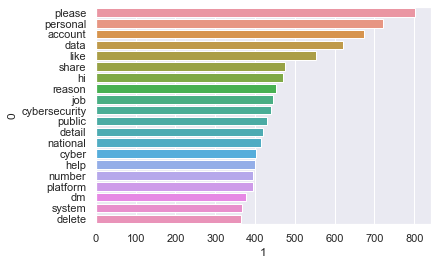

In [26]:
sns.barplot(data = freq_data, x = 1, y = 0);

In [27]:
most_common = []

for key in fdist.most_common(20):
    most_common.append(key[0])
    
most_common

['please',
 'personal',
 'account',
 'data',
 'like',
 'share',
 'hi',
 'reason',
 'job',
 'cybersecurity',
 'public',
 'detail',
 'national',
 'cyber',
 'help',
 'number',
 'platform',
 'dm',
 'system',
 'delete']

## Clustering

In [27]:
%%time 
range_k = [i for i in range(1, 4)]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k)

running Kmeans with k=1
running Kmeans with k=2
running Kmeans with k=3
Wall time: 53.9 s


In [28]:
results_k

{1: 109557.00907543932, 2: 106099.9003592337, 3: 105194.8191271004}

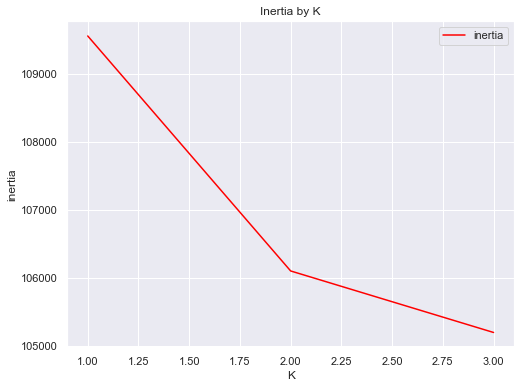

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();

## Cluster Analysis

In [56]:
estimator_kmeans = KMeans(random_state=42, n_clusters=3) # try 2, 3, 8 clusters.
estimator_kmeans.fit(text_vec)

KMeans(n_clusters=3, random_state=42)

In [31]:
text_vec["cluster_id"] = estimator_kmeans.labels_
text_vec.head()

,0000,0088email,01,0113,0121,01227,01432,01482,0151,01552,...,zoom,zscaler,zu,zubair,zuckerberg,zvakaoma,zx,zyalsss,zürich,cluster_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [32]:
text_clusters = text_vec.groupby('cluster_id').sum()
text_clusters.head()

,0000,0088email,01,0113,0121,01227,01432,01482,0151,01552,...,zoo,zoom,zscaler,zu,zubair,zuckerberg,zvakaoma,zx,zyalsss,zürich
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
text_clusters_20 = text_clusters[['please',
 'personal',
 'account',
 'like',
 'share',
 'hi',
 'reason',
 'job',
 'cybersecurity',
 'public',
 'detail',
 'national',
 'cyber',
 'help',
 'number',
 'platform',
 'dm',
 'system',
 'delete',
 'access']
]

text_clusters_20.head()

,please,personal,account,like,share,hi,reason,job,cybersecurity,public,detail,national,cyber,help,number,platform,dm,system,delete,access
cluster_id,,,,,,,,,,,,,,,,,,,,
0,172.0,282.0,150.0,309.0,145.0,100.0,57.0,323.0,417.0,161.0,89.0,390.0,353.0,308.0,163.0,99.0,17.0,334.0,19.0,246.0
1,269.0,270.0,167.0,185.0,270.0,185.0,267.0,0.0,0.0,185.0,175.0,0.0,0.0,6.0,3.0,270.0,122.0,0.0,258.0,0.0
2,328.0,155.0,243.0,45.0,48.0,186.0,127.0,0.0,0.0,78.0,130.0,0.0,1.0,78.0,144.0,20.0,232.0,6.0,85.0,92.0


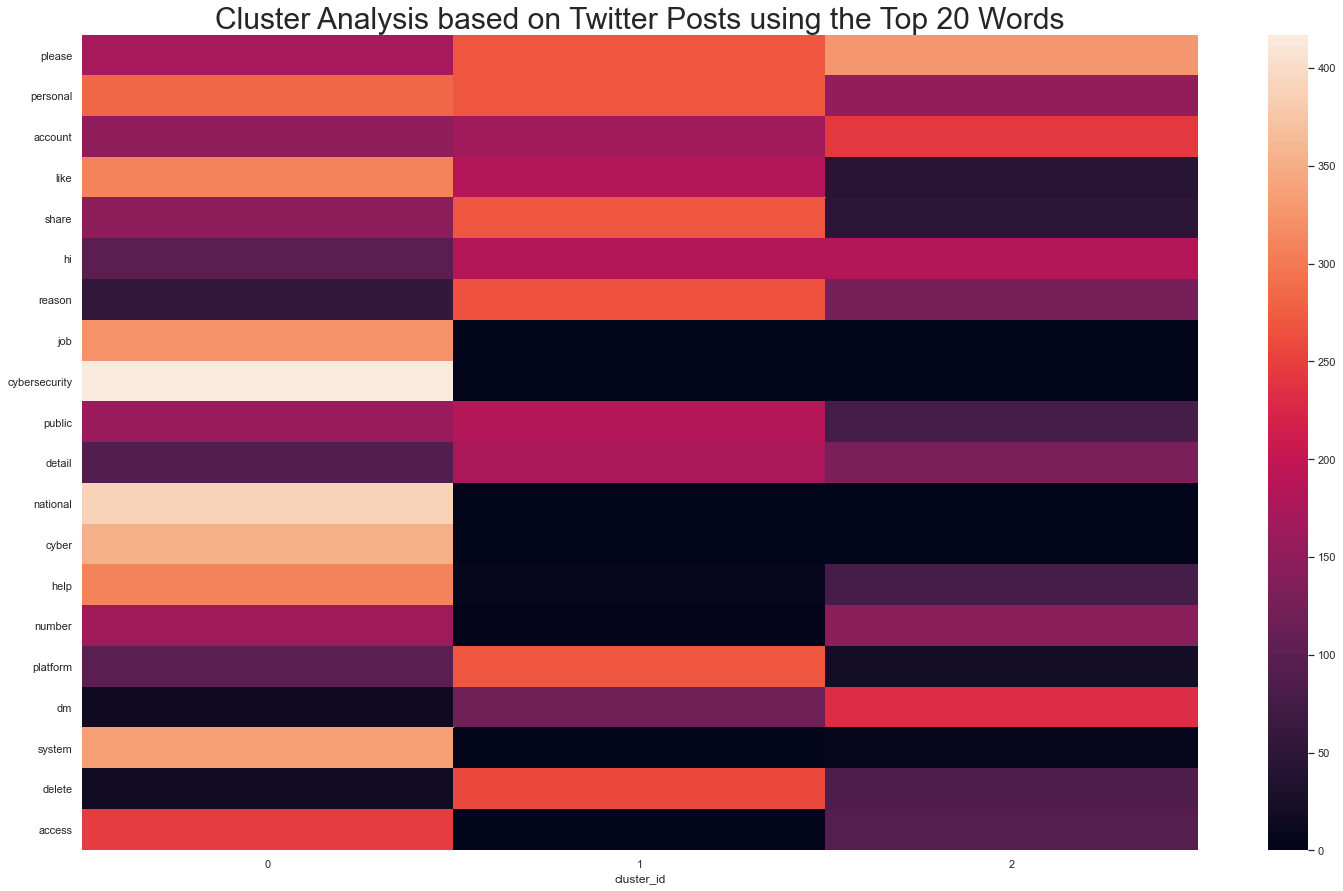

In [34]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(text_clusters_20.transpose(), annot=False)
plt.title("Cluster Analysis based on Twitter Posts using the Top 20 Words", size = 30);

## Sentiment Analysis

In [28]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()
text['scores'] = text['text'].apply(lambda review: sid_obj.polarity_scores(review))

In [29]:
text.head()

,text,scores
0,priti patels new threat british journalist bloody hell shes change secrecy law journalist others jail 14 year publishing government claim damage national authoritarianism,"{'neg': 0.426, 'neu': 0.574, 'pos': 0.0, 'compound': -0.9337}"
1,healthcare organization continue greatly depend flow better support patient care must establish better practice secure access service edge sase model come cybersecurity,"{'neg': 0.0, 'neu': 0.542, 'pos': 0.458, 'compound': 0.9241}"
2,next 10 year fhe could even help researcher find association specific gene mutation analyzing genetic across thousand encrypted sle,"{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compound': 0.4019}"
3,joynewsontv police must review sop corrective action preventive action address national issue camera working gathering long going sit plan,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
4,join npcindiagov webinar manual preparation document iso 270012013 management systemdate time 19062021 0330 pm 0500 pmto register,"{'neg': 0.0, 'neu': 0.879, 'pos': 0.121, 'compound': 0.296}"


In [30]:
text['compound']  = text['scores'].apply(lambda score_dict: score_dict['compound'])
text.head()

,text,scores,compound
0,priti patels new threat british journalist bloody hell shes change secrecy law journalist others jail 14 year publishing government claim damage national authoritarianism,"{'neg': 0.426, 'neu': 0.574, 'pos': 0.0, 'compound': -0.9337}",-0.9337
1,healthcare organization continue greatly depend flow better support patient care must establish better practice secure access service edge sase model come cybersecurity,"{'neg': 0.0, 'neu': 0.542, 'pos': 0.458, 'compound': 0.9241}",0.9241
2,next 10 year fhe could even help researcher find association specific gene mutation analyzing genetic across thousand encrypted sle,"{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compound': 0.4019}",0.4019
3,joynewsontv police must review sop corrective action preventive action address national issue camera working gathering long going sit plan,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000
4,join npcindiagov webinar manual preparation document iso 270012013 management systemdate time 19062021 0330 pm 0500 pmto register,"{'neg': 0.0, 'neu': 0.879, 'pos': 0.121, 'compound': 0.296}",0.2960


In [31]:
text['comp_score'] = text['compound'].apply(lambda c: 'pos' if c >=0.05 else ('neg' if c <= -0.05 else 'neutral'))

text.head()

,text,scores,compound,comp_score
0,priti patels new threat british journalist bloody hell shes change secrecy law journalist others jail 14 year publishing government claim damage national authoritarianism,"{'neg': 0.426, 'neu': 0.574, 'pos': 0.0, 'compound': -0.9337}",-0.9337,neg
1,healthcare organization continue greatly depend flow better support patient care must establish better practice secure access service edge sase model come cybersecurity,"{'neg': 0.0, 'neu': 0.542, 'pos': 0.458, 'compound': 0.9241}",0.9241,pos
2,next 10 year fhe could even help researcher find association specific gene mutation analyzing genetic across thousand encrypted sle,"{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compound': 0.4019}",0.4019,pos
3,joynewsontv police must review sop corrective action preventive action address national issue camera working gathering long going sit plan,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral
4,join npcindiagov webinar manual preparation document iso 270012013 management systemdate time 19062021 0330 pm 0500 pmto register,"{'neg': 0.0, 'neu': 0.879, 'pos': 0.121, 'compound': 0.296}",0.2960,pos


In [32]:
comp_score_counts = text.comp_score.value_counts()

In [203]:
colours = {'pos': 'salmon',
           'neutral': 'darkgray',
           'neg': 'teal'}
labels = ['pos','neutral', 'neg']

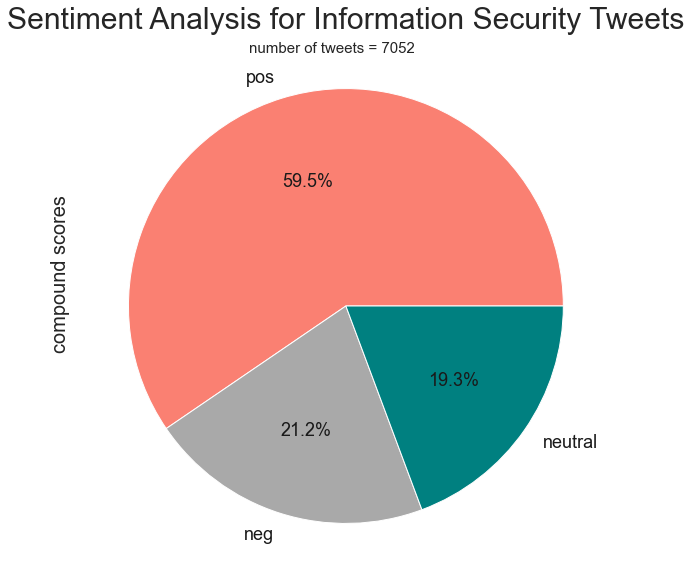

In [205]:
fig, ax = plt.subplots(figsize=(15,10))
comp_score_counts.plot.pie(autopct="%.1f%%", colors=['salmon','darkgray','teal'], textprops={'fontsize': 18, "color": "k"})
plt.title("Sentiment Analysis for Information Security Tweets", size = 30)
plt.ylabel("compound scores", size = 20, y = .56)
plt.suptitle('number of tweets = 7052', size = 15, y = .87);

# Other columns

## Cleaning

In [36]:
ident = data[["verified", "lang", "location", "followers_count", "description", "user_id"]] # can always change later
ident = ident.drop_duplicates()

In [37]:
ident = ident.dropna()
ident.head()

,verified,lang,location,followers_count,description,user_id
0,False,en,"Portsmouth, England",10760,"#Gaza #KillTheBill #BLM ex-labour, nat living wage £15 all workers rights!! DEM SOCIALIST #Resist #WeSupportCorbyn #ICantBreathe #AusterityKills #ToryLiesKill",x1030495583759478784
1,False,en,"Chapel Hill, NC",547,"Founder & CEO, @VigeoAlliance | Culture & #Diversity Risk Assessment | #TransformationalLeadership | #CommunityRelations | Motivational Speaking",x826314436755517441
2,False,en,"New Haven, CT",868,"writing, knitting, running | she/her.",x24552048
3,False,en,Tema,12,Because am happy,x1279673714603429888
4,True,en,"New Delhi, India",4320,"The Union Minister for Commerce & Industry is the President of the NPC, and the Secretary, Department for Promotion of Industry & Internal Trade is Chairman.",x3283206152


In [38]:
ident.shape

(3576, 6)

In [39]:
ident['description'] = ident['description'].apply(cleanTxt)

ident.head()

,verified,lang,location,followers_count,description,user_id
0,False,en,"Portsmouth, England",10760,gaza killthebill blm exlabour nat living wage 15 all workers rights dem socialist resist wesupportcorbyn icantbreathe austeritykills torylieskill,x1030495583759478784
1,False,en,"Chapel Hill, NC",547,founder ceo vigeoalliance culture diversity risk assessment transformationalleadership communityrelations motivational speaking,x826314436755517441
2,False,en,"New Haven, CT",868,writing knitting running sheher,x24552048
3,False,en,Tema,12,because am happy,x1279673714603429888
4,True,en,"New Delhi, India",4320,the union minister for commerce industry is the president of the npc and the secretary department for promotion of industry internal trade is chairman,x3283206152


In [40]:
ident['description'] = ident['description'].apply(stopWords)

In [41]:
desc = ident[['description']]
desc.head()

,description
0,gaza killthebill blm exlabour nat living wage 15 worker right dem socialist resist wesupportcorbyn icantbreathe austeritykills torylieskill
1,founder ceo vigeoalliance culture diversity risk assessment transformationalleadership communityrelations motivational speaking
2,writing knitting running sheher
3,happy
4,union minister commerce industry president npc secretary department promotion industry internal trade chairman


In [42]:
desc_lst = []
for row in desc['description']:
    desc_lst.append(row)

desc_lst[:5]

['gaza killthebill blm exlabour nat living wage 15 worker right dem socialist resist wesupportcorbyn icantbreathe austeritykills torylieskill',
 'founder ceo vigeoalliance culture diversity risk assessment transformationalleadership communityrelations motivational speaking',
 'writing knitting running sheher',
 'happy',
 'union minister commerce industry president npc secretary department promotion industry internal trade chairman']

In [43]:
desc_vec = pd.DataFrame(tv.fit_transform(desc_lst).toarray(), columns = tv.get_feature_names())
desc_vec.head()

,001,00120c,003,00301j,004,010,0114,01274,01332,01337,...,zymolysist,ángel,área,áreas,ärt,æstivas,çaign,écoles,élelle,über
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Word list

In [44]:
desc_words = []

for row in desc['description']:
    for word in str(row).split(" "):
        desc_words.append(word)
        
desc_words[:5]

#confusing outputs

['gaza', 'killthebill', 'blm', 'exlabour', 'nat']

In [45]:
from nltk.probability import FreqDist
fdist_desc = FreqDist()
for word in desc_words:
    fdist_desc[word]+=1
fdist_desc

FreqDist({'tweet': 366, 'service': 314, 'business': 276, 'help': 241, 'account': 238, 'solution': 230, 'technology': 221, 'news': 216, 'follow': 215, 'job': 197, ...})

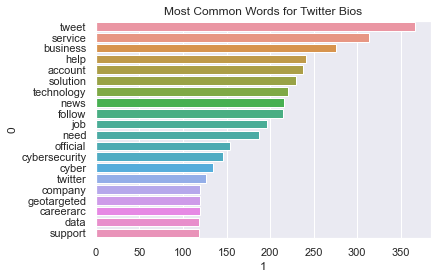

In [46]:
freq_data_desc = pd.DataFrame.from_dict(fdist_desc.most_common(20))
rel = sns.barplot(data = freq_data_desc, x = 1, y = 0).set(title='Most Common Words for Twitter Bios')


In [47]:
most_common_desc = []

for key in fdist_desc.most_common(20):
    most_common_desc.append(key[0])
    
most_common_desc

['tweet',
 'service',
 'business',
 'help',
 'account',
 'solution',
 'technology',
 'news',
 'follow',
 'job',
 'need',
 'official',
 'cybersecurity',
 'cyber',
 'twitter',
 'company',
 'geotargeted',
 'careerarc',
 'data',
 'support']

## Clustering

In [52]:
%%time 
range_k = [i for i in range(1, 9)]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k)

running Kmeans with k=1
running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=6
running Kmeans with k=7
running Kmeans with k=8
Wall time: 4min 24s


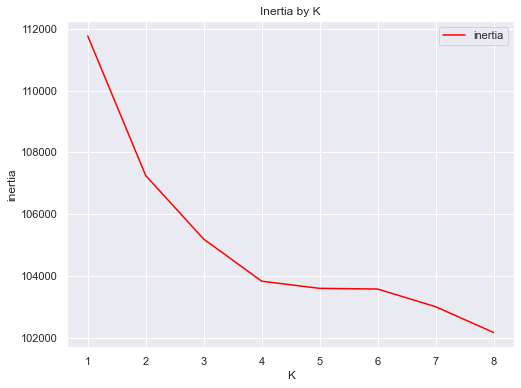

In [53]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();
#look like 4 to me

## Cluster Analysis

In [54]:
estimator_kmeans = KMeans(random_state=42, n_clusters=4) 
estimator_kmeans.fit(desc_vec)

KMeans(n_clusters=4, random_state=42)

In [55]:
desc_vec["cluster_id"] = estimator_kmeans.labels_
desc_vec.head()

,001,00120c,003,00301j,004,010,0114,01274,01332,01337,...,ángel,área,áreas,ärt,æstivas,çaign,écoles,élelle,über,cluster_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [56]:
desc_clusters = desc_vec.groupby('cluster_id').sum()
desc_clusters.head()

,001,00120c,003,00301j,004,010,0114,01274,01332,01337,...,zymolysist,ángel,área,áreas,ärt,æstivas,çaign,écoles,élelle,über
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
desc_clusters_20 = desc_clusters[['tweet',
 'service',
 'business',
 'help',
 'account',
 'solution',
 'technology',
 'news',
 'follow',
 'job',
 'need',
 'official',
 'cybersecurity',
 'cyber',
 'twitter',
 'company',
 'geotargeted',
 'careerarc',
 'data',
 'support']]

desc_clusters_20


,tweet,service,business,help,account,solution,technology,news,follow,job,need,official,cybersecurity,cyber,twitter,company,geotargeted,careerarc,data,support
cluster_id,,,,,,,,,,,,,,,,,,,,
0,120.0,0.0,0.0,120.0,120.0,0.0,0.0,0.0,120.0,120.0,120.0,0.0,0.0,0.0,0.0,0.0,120.0,120.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,125.0,284.0,248.0,120.0,113.0,217.0,209.0,185.0,87.0,64.0,65.0,154.0,132.0,123.0,127.0,117.0,0.0,0.0,101.0,106.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


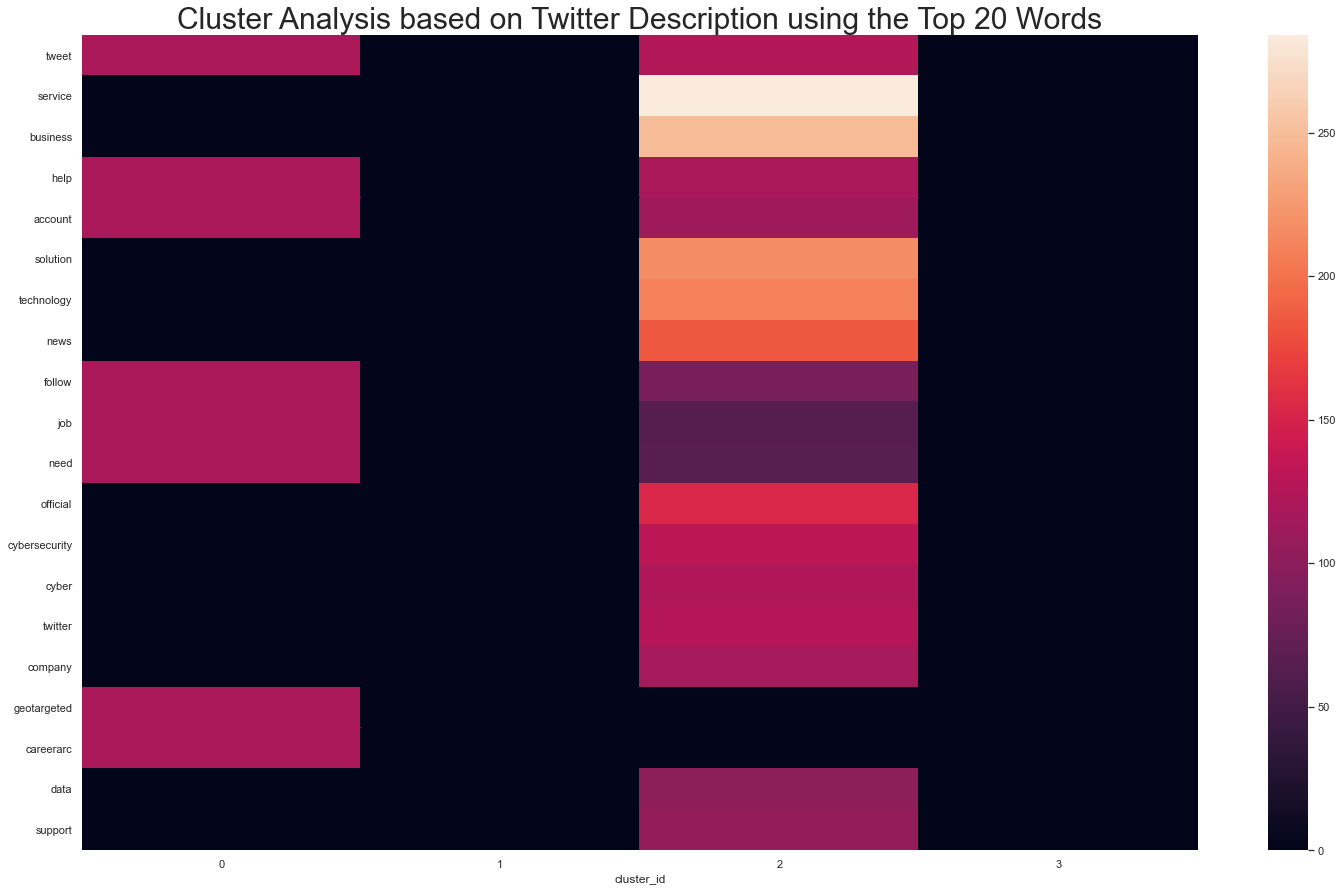

In [86]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(desc_clusters_20.transpose(), annot=False)
plt.title("Cluster Analysis based on Twitter Description using the Top 20 Words", size = 30);

In [74]:
df2 = data[["created_at", "is_quote", "retweet_count", "location", "followers_count", "friends_count", "listed_count", "account_created_at", "verified"]][:3000]
df2.head()

,created_at,is_quote,retweet_count,location,followers_count,friends_count,listed_count,account_created_at,verified
0,2021-06-16 17:23:28,False,1,"Portsmouth, England",10760,9194,19,2018-08-17 16:44:27,False
1,2021-06-16 17:21:00,False,0,"Chapel Hill, NC",547,32,0,2017-01-31 06:21:28,False
2,2021-06-16 17:20:21,False,0,"New Haven, CT",868,786,19,2009-03-15 17:15:52,False
3,2021-06-16 17:20:06,False,0,Tema,12,105,0,2020-07-05 07:09:42,False
4,2021-06-16 17:20:05,False,2,"New Delhi, India",4320,745,33,2015-07-18 09:15:18,True


In [75]:
from datetime import datetime, date
df2[["created_at"]] = df2[["created_at"]].apply(pd.to_datetime)

In [76]:
df2['year_account_created'] = pd.DatetimeIndex(df2["account_created_at"]).year
df2 = df2.drop(["created_at", "account_created_at"], axis=1)
df2['year_account_created'] = df2["year_account_created"].astype("category")
df2.head()

,is_quote,retweet_count,location,followers_count,friends_count,listed_count,verified,year_account_created
0,False,1,"Portsmouth, England",10760,9194,19,False,2018
1,False,0,"Chapel Hill, NC",547,32,0,False,2017
2,False,0,"New Haven, CT",868,786,19,False,2009
3,False,0,Tema,12,105,0,False,2020
4,False,2,"New Delhi, India",4320,745,33,True,2015


In [77]:
%%time
df2['country'] = df2[['location']][:1000].apply(findCountry)
df2.head() 
#try 300

Wall time: 108 ms


,is_quote,retweet_count,location,followers_count,friends_count,listed_count,verified,year_account_created,country
0,False,1,"Portsmouth, England",10760,9194,19,False,2018,NaN
1,False,0,"Chapel Hill, NC",547,32,0,False,2017,NaN
2,False,0,"New Haven, CT",868,786,19,False,2009,NaN
3,False,0,Tema,12,105,0,False,2020,NaN
4,False,2,"New Delhi, India",4320,745,33,True,2015,NaN


In [78]:
df2 = df2.drop('location', axis = 1)

In [79]:
numerical_data = df2.select_dtypes(np.number)
categorical_data = df2.drop(numerical_data, axis = 1)

## Processing

In [80]:
from sklearn.preprocessing import MinMaxScaler

numerical_data_normalized = MinMaxScaler().fit_transform(numerical_data) # this line scales our data

numerical_data_normalized = pd.DataFrame(              #this pops it back in data frame format 
    numerical_data_normalized,
    columns=numerical_data.columns) 

numerical_data_normalized.head()

,retweet_count,followers_count,friends_count,listed_count
0,0.001698,2.155295e-04,0.062788,0.000091
1,0.000000,1.095675e-05,0.000219,0.000000
2,0.000000,1.738658e-05,0.005368,0.000091
3,0.000000,2.403675e-07,0.000717,0.000000
4,0.003396,8.653230e-05,0.005088,0.000157


In [81]:
categorical_data_codified = pd.get_dummies(
                                    categorical_data, 
                                    drop_first=True,
                                    dtype="int64"
).reset_index()
categorical_data_codified.head()

,index,is_quote,verified,year_account_created_2008,year_account_created_2009,year_account_created_2010,year_account_created_2011,year_account_created_2012,year_account_created_2013,year_account_created_2014,year_account_created_2015,year_account_created_2016,year_account_created_2017,year_account_created_2018,year_account_created_2019,year_account_created_2020,year_account_created_2021
0,0,False,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,False,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2,False,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,3,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,False,True,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [82]:
categorical_data_codified = categorical_data_codified.drop('index', axis = 1)


In [83]:
df2_processed = pd.concat([
                            numerical_data_normalized,
                            categorical_data_codified
                        ], axis=1
).reset_index()

In [84]:
df2_processed = df2_processed.drop('index', axis = 1)


In [85]:
df2_processed.head()


,retweet_count,followers_count,friends_count,listed_count,is_quote,verified,year_account_created_2008,year_account_created_2009,year_account_created_2010,year_account_created_2011,year_account_created_2012,year_account_created_2013,year_account_created_2014,year_account_created_2015,year_account_created_2016,year_account_created_2017,year_account_created_2018,year_account_created_2019,year_account_created_2020,year_account_created_2021
0,0.001698,2.155295e-04,0.062788,0.000091,False,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.000000,1.095675e-05,0.000219,0.000000,False,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0.000000,1.738658e-05,0.005368,0.000091,False,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0.000000,2.403675e-07,0.000717,0.000000,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.003396,8.653230e-05,0.005088,0.000157,False,True,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [71]:
%%time 
range_k = [2, 3, 4, 5, 8, 10, 15, 20, 25, 30]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k)

running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=8
running Kmeans with k=10
running Kmeans with k=15
running Kmeans with k=20
running Kmeans with k=25
running Kmeans with k=30
Wall time: 12min 3s


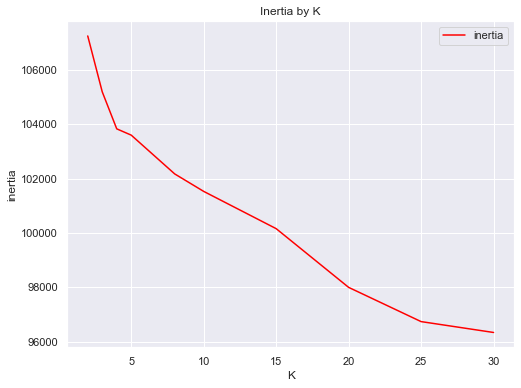

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();

In [73]:
estimator_kmeans = KMeans(random_state=42, n_clusters=10) # maybe 25?
estimator_kmeans.fit(df2_processed)

KMeans(n_clusters=10, random_state=42)

In [74]:
df2["cluster_id"] = estimator_kmeans.labels_
df2.head()

,is_quote,retweet_count,followers_count,friends_count,listed_count,verified,year_account_created,country,cluster_id
0,False,1,10760,9194,19,False,2018,NaN,4
1,False,0,547,32,0,False,2017,NaN,9
2,False,0,868,786,19,False,2009,NaN,2
3,False,0,12,105,0,False,2020,NaN,5
4,False,2,4320,745,33,True,2015,NaN,9


In [75]:
df2.cluster_id.value_counts()

4    494
3    438
1    346
2    304
0    294
9    281
6    277
8    210
5    203
7    153
Name: cluster_id, dtype: int64

In [76]:
cluster_summary(1, df2)

{'is_quote': 0.005780346820809248,
 'verified': 0.6560693641618497,
 'year_account_created': 2012,
 'country': nan,
 'retweet_count': 0.2543352601156069,
 'followers_count': 109770.37283236995,
 'friends_count': 3061.1531791907514,
 'listed_count': 134.8612716763006,
 'cluster_id': 1.0}

In [77]:
cluster_comparison(0,1,2,3,4,5,6,7,8,9)

cluster_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
is_quote,0.010204,0.005780,0.023026,0.002283,0.028340,0.014778,1.805054e-02,0.006536,0.014286,0.028470
verified,0.231293,0.656069,0.000000,1.000000,0.000000,0.064039,4.079422e-01,0.006536,0.209524,0.153025
year_account_created,2011.000000,2012.000000,2009.000000,2009.000000,2018.000000,2020.000000,2.013000e+03,2021.000000,2010.000000,2015.000000
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retweet_count,2.687075,0.254335,0.519737,1.568493,2.000000,0.773399,3.465704e-01,6.601307,0.938095,4.964413
followers_count,31999.316327,109770.372832,3609.953947,696553.397260,3720.180162,4486.334975,1.529769e+06,407.052288,108852.490476,9687.163701
friends_count,2634.653061,3061.153179,1068.720395,9442.826484,1157.376518,346.704433,1.055534e+03,443.398693,1745.071429,1010.088968
listed_count,332.377551,134.861272,171.667763,2751.847032,95.325911,5.566502,5.997184e+02,0.705882,303.304762,57.882562


In [78]:
cluster_results = kmeans_cluster(df2_processed, 5)
cluster_summary2 = graph_summary_clustering(cluster_results)

In [79]:
cluster_summary2

,followers_count,friends_count,is_quote,listed_count,retweet_count,verified,year_account_created_2008,year_account_created_2009,year_account_created_2010,year_account_created_2011,year_account_created_2012,year_account_created_2013,year_account_created_2014,year_account_created_2015,year_account_created_2016,year_account_created_2017,year_account_created_2018,year_account_created_2019,year_account_created_2020,year_account_created_2021
Cluster,,,,,,,,,,,,,,,,,,,,
0,0.000641,0.017993,0.010204,0.001586,0.004562,0.231293,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.010578,0.053118,0.000000,0.009455,0.006229,1.000000,0.087607,0.0,0.094017,0.0,0.485043,0.0,0.091880,0.068376,0.055556,0.023504,0.012821,0.004274,0.027778,0.002137
2,0.000070,0.008673,0.022811,0.000376,0.003249,0.000000,0.049301,0.0,0.122149,0.0,0.087564,0.0,0.061074,0.091979,0.066961,0.083149,0.099338,0.078734,0.139809,0.111847
3,0.004015,0.017178,0.013289,0.003156,0.001021,0.495017,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.030642,0.007209,0.018051,0.002862,0.000588,0.407942,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


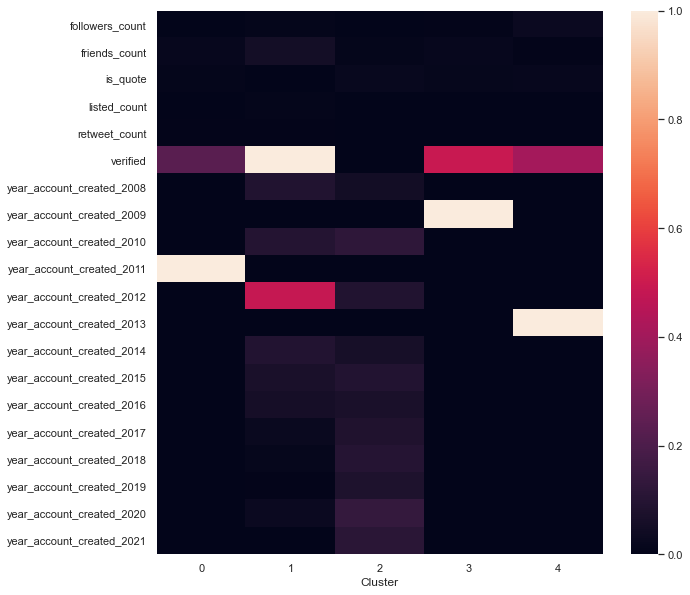

In [80]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cluster_summary2.transpose(), annot=False);

### Cluster 0-3 in Description

In [87]:
def mainWords(cluster_data):
    main = []
    n = len(cluster_data.index) 
    for col in cluster_data.columns:
        if cluster_data[col].sum() > float(n/3):
            main += [col]
    return main

In [88]:
cluster_0 = desc_vec[desc_vec.cluster_id == 0]
print(cluster_0.head())
print(mainWords(cluster_0.drop('cluster_id', axis = 1)))

    001  00120c  003  00301j  004  010  0114  01274  01332  01337  ...  ángel  \
17  0.0  0.0     0.0  0.0     0.0  0.0  0.0   0.0    0.0    0.0    ...  0.0     
30  0.0  0.0     0.0  0.0     0.0  0.0  0.0   0.0    0.0    0.0    ...  0.0     
33  0.0  0.0     0.0  0.0     0.0  0.0  0.0   0.0    0.0    0.0    ...  0.0     
52  0.0  0.0     0.0  0.0     0.0  0.0  0.0   0.0    0.0    0.0    ...  0.0     
67  0.0  0.0     0.0  0.0     0.0  0.0  0.0   0.0    0.0    0.0    ...  0.0     

    área  áreas  ärt  æstivas  çaign  écoles  élelle  über  cluster_id  
17  0.0   0.0    0.0  0.0      0.0    0.0     0.0     0.0   0           
30  0.0   0.0    0.0  0.0      0.0    0.0     0.0     0.0   0           
33  0.0   0.0    0.0  0.0      0.0    0.0     0.0     0.0   0           
52  0.0   0.0    0.0  0.0      0.0    0.0     0.0     0.0   0           
67  0.0   0.0    0.0  0.0      0.0    0.0     0.0     0.0   0           

[5 rows x 12492 columns]
['account', 'careerarc', 'follow', 'geotargeted',

In [91]:
cluster_1 = desc_vec[desc_vec.cluster_id == 1]
print(cluster_1.head())
print(mainWords(cluster_1.drop('cluster_id', axis = 1)))

      001  00120c  003  00301j  004  010  0114  01274  01332  01337  ...  \
3526  0.0  0.0     0.0  0.0     0.0  0.0  0.0   0.0    0.0    0.0    ...   

      ángel  área  áreas  ärt  æstivas  çaign  écoles  élelle  über  \
3526  0.0    0.0   0.0    0.0  0.0      0.0    0.0     0.0     0.0    

      cluster_id  
3526  1           

[1 rows x 12492 columns]
['5082386334', 'ac', 'boston', 'client', 'contact', 'equipped', 'fullservice', 'industry', 'premier', 'provider', 'sector', 'size', 'solution', 'work']


In [93]:
cluster_2 = desc_vec[desc_vec.cluster_id == 2]
cluster_2.head()


,001,00120c,003,00301j,004,010,0114,01274,01332,01337,...,ángel,área,áreas,ärt,æstivas,çaign,écoles,élelle,über,cluster_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [94]:
print(mainWords(cluster_2.drop('cluster_id', axis = 1)))

#nothing?

[]


In [104]:
cluster_3 = desc_vec[desc_vec.cluster_id == 3]
print(cluster_3.head())
print(mainWords(cluster_3.drop('cluster_id', axis = 1)))

      001  00120c  003  00301j  004  010  0114  01274  01332  01337  ...  \
3132  0.0  0.0     0.0  0.0     0.0  0.0  0.0   0.0    0.0    0.0    ...   

      ángel  área  áreas  ärt  æstivas  çaign  écoles  élelle  über  \
3132  0.0    0.0   0.0    0.0  0.0      0.0    0.0     0.0     0.0    

      cluster_id  
3132  3           

[1 rows x 12492 columns]
['1831', 'defence', 'founded', 'institute', 'oldest', 'royal', 'rusi', 'service', 'study', 'tank', 'think', 'united', 'world']


## Word Cloud

In [86]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

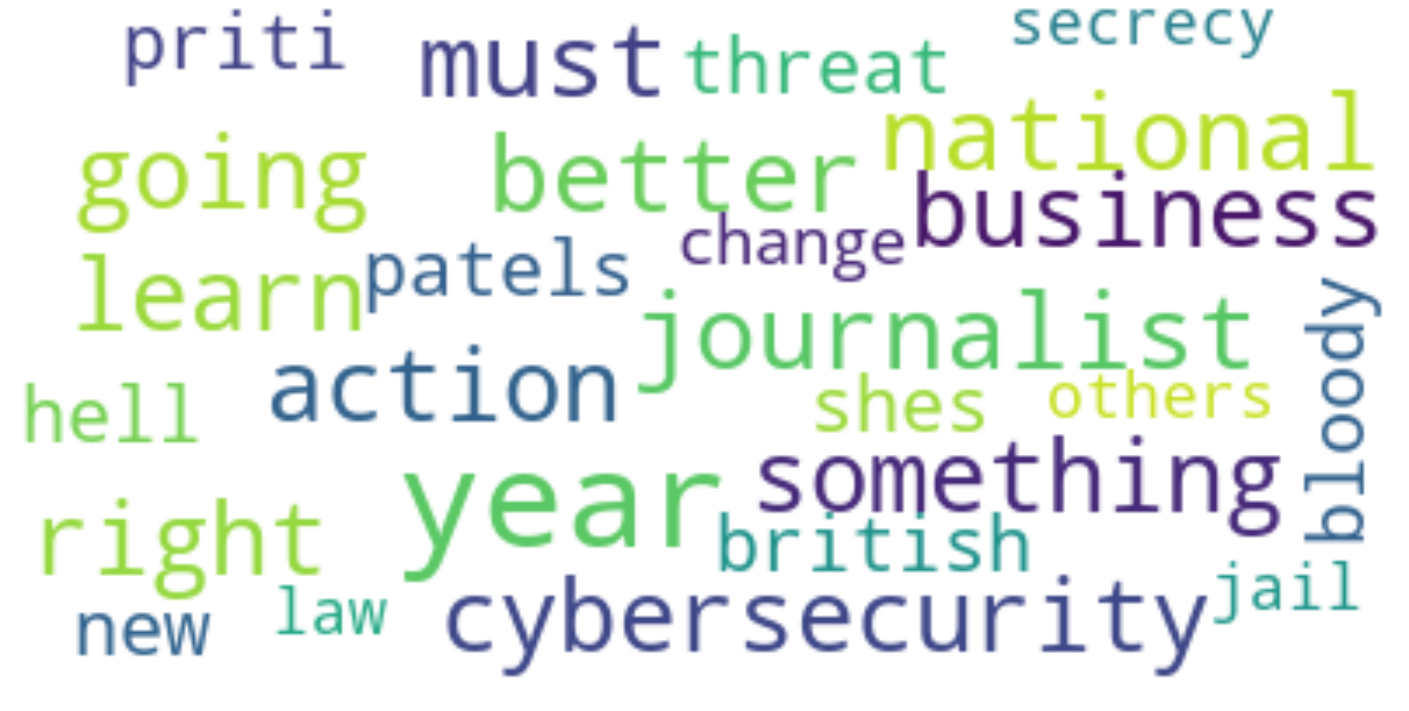

In [87]:
stopwords = set(STOPWORDS)
new_stopwords=stopwords.union(text['text'])
wc = WordCloud(
         background_color="white", max_words=2000,
         min_font_size =15, max_font_size=40, relative_scaling =
         0.5, stopwords=new_stopwords,normalize_plurals= True)
import re
textonly = re.sub("", "",str(text['text']))
wc.generate(textonly)
plt.figure(figsize=(25,25))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
#Show the wordcloud
plt.show()

## Location Analysis

In [88]:
df1 = splitData(data, 1700)[0]
df2 = splitData(data, 1700)[1]
df3 = splitData(data, 1700)[2]
df4 = splitData(data, 1700)[3]

4.0
4.0
4.0
4.0


In [89]:
%%time 
df1['country'] = df1['location'].apply(findCountry)

Wall time: 7min 53s


In [90]:
%%time 
df2['country'] = df2['location'].apply(findCountry)

Wall time: 10min 53s


In [91]:
%%time
df3['country'] = df3['location'].apply(findCountry)

Wall time: 10min 23s


In [92]:
%%time
df4['country'] = df4['location'].apply(findCountry)

Wall time: 12min 30s


In [110]:
data = pd.concat([df1, df2, df3, df4])
data[['country']].head()

,country
0,United Kingdom
1,United States
2,中国
3,Ghana
4,India


In [111]:
data[["created_at"]] = data[["created_at"]].apply(pd.to_datetime)
data['day_post_created'] = pd.DatetimeIndex(data["created_at"]).day
data['year_account_created'] = pd.DatetimeIndex(data["account_created_at"]).year
data['year_account_created'] = data["year_account_created"].astype("category")

In [112]:
data_processed = data.copy()
data_processed.to_csv('data_infosec_processed.csv', index = True)

### Other analysis

In [113]:
df2 = pd.read_csv('data_infosec_processed.csv')

In [114]:
df2 = data[["country", "is_quote", "retweet_count", "day_post_created", "followers_count", "friends_count", 
              "listed_count", "verified", "year_account_created"]]
df2.head()

,country,is_quote,retweet_count,day_post_created,followers_count,friends_count,listed_count,verified,year_account_created
0,United Kingdom,False,1.0,16.0,10760.0,9194.0,19,False,2018.0
1,United States,False,0.0,16.0,547.0,32.0,0,False,2017.0
2,中国,False,0.0,16.0,868.0,786.0,19,False,2009.0
3,Ghana,False,0.0,16.0,12.0,105.0,0,False,2020.0
4,India,False,2.0,16.0,4320.0,745.0,33,True,2015.0


In [115]:
df2['followers_count'] = df2['followers_count'].astype("float64")
df2['friends_count'] = df2['friends_count'].astype("float64")
df2['retweet_count'] = df2['retweet_count'].astype("float64")
df2['age_of_account'] = 2021 - df2['year_account_created'].astype("float64")
df2['day_post_created'] = df2['day_post_created'].astype("float64")
df2['verified'] = df2['verified'].astype("object")

In [116]:
df2['country'].value_counts()

Unknown           4292
United States     3426
United Kingdom    1118
India             857 
Global            411 
                 ...  
Madagasikara      1   
Tchad تشاد        1   
Slovenija         1   
Asia              1   
Malawi            1   
Name: country, Length: 129, dtype: int64

In [117]:
df2.dropna(inplace=True)

In [118]:
df2.isna().sum()

country                 0
is_quote                0
retweet_count           0
day_post_created        0
followers_count         0
friends_count           0
listed_count            0
verified                0
year_account_created    0
age_of_account          0
dtype: int64

In [119]:
df2.shape

(5352, 10)

In [120]:
df2['is_quote'] = df2['is_quote'].astype("object")

In [121]:
df2 = df2.drop('year_account_created', axis = 1)

In [122]:
df2.dtypes

country             object 
is_quote            object 
retweet_count       float64
day_post_created    float64
followers_count     float64
friends_count       float64
listed_count        int64  
verified            object 
age_of_account      float64
dtype: object

In [123]:
numerical_data = df2.select_dtypes(np.number)
categorical_data = df2.drop(numerical_data, axis = 1)

In [124]:
from sklearn.preprocessing import MinMaxScaler

numerical_data_normalized = MinMaxScaler().fit_transform(numerical_data) # this line scales our data

numerical_data_normalized = pd.DataFrame(              #this pops it back in data frame format 
    numerical_data_normalized,
    columns=numerical_data.columns) 

numerical_data_normalized.head()

,retweet_count,day_post_created,followers_count,friends_count,listed_count,age_of_account
0,0.000655,1.0,1.763461e-04,0.033261,0.000101,0.200000
1,0.000000,1.0,8.964807e-06,0.000116,0.000000,0.266667
2,0.000000,1.0,1.422569e-05,0.002844,0.000101,0.800000
3,0.000000,1.0,1.966685e-07,0.000380,0.000000,0.066667
4,0.001310,1.0,7.080067e-05,0.002695,0.000175,0.400000


In [125]:
categorical_data_codified = pd.get_dummies(
                                    categorical_data, 
                                    drop_first=True,
                                    dtype="int64"
).reset_index()
categorical_data_codified.head()

,index,country_Angola,country_Argentina,country_Australia,country_Ayiti,country_Azərbaycan,country_België / Belgique / Belgien,country_Bermuda,country_Bosna i Hercegovina / Босна и Херцеговина,country_Botswana,...,country_ประเทศไทย,country_ປະເທດລາວ,country_မြန်မာ,country_ኢትዮጵያ,country_中国,country_日本,country_臺灣,country_대한민국,is_quote_True,verified_True
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [126]:
categorical_data_codified = categorical_data_codified[['country_United States', 'country_Unknown', 
                                                       'country_United Kingdom', 'country_Global', 
                                                       'country_India', 'is_quote_True', 'verified_True']]

In [127]:
df2_processed = pd.concat([
                            numerical_data_normalized,
                            categorical_data_codified
                        ], axis=1
).reset_index()

In [128]:
df2_processed = df2_processed.drop('index', axis = 1)

In [129]:
df2_processed.head()

,retweet_count,day_post_created,followers_count,friends_count,listed_count,age_of_account,country_United States,country_Unknown,country_United Kingdom,country_Global,country_India,is_quote_True,verified_True
0,0.000655,1.0,1.763461e-04,0.033261,0.000101,0.200000,0,0,1,0,0,0,0
1,0.000000,1.0,8.964807e-06,0.000116,0.000000,0.266667,1,0,0,0,0,0,0
2,0.000000,1.0,1.422569e-05,0.002844,0.000101,0.800000,0,0,0,0,0,0,0
3,0.000000,1.0,1.966685e-07,0.000380,0.000000,0.066667,0,0,0,0,0,0,0
4,0.001310,1.0,7.080067e-05,0.002695,0.000175,0.400000,0,0,0,0,1,0,1


### Clustering

In [57]:
%%time 
range_k = [2, 3, 4, 5, 8, 10, 15, 20, 25, 30]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k)

running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=8
running Kmeans with k=10
running Kmeans with k=15
running Kmeans with k=20
running Kmeans with k=25
running Kmeans with k=30
Wall time: 23min 19s


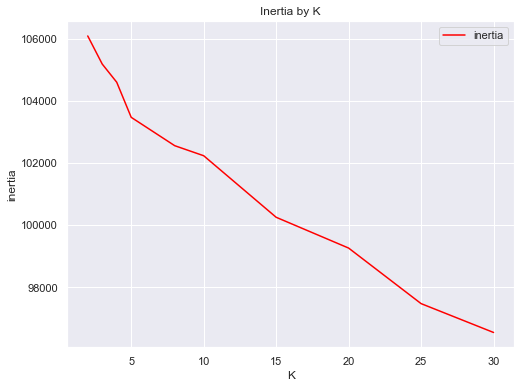

In [58]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();

In [59]:
estimator_kmeans = KMeans(random_state=42, n_clusters=25) 
estimator_kmeans.fit(df2_processed)

KMeans(n_clusters=25, random_state=42)

In [60]:
df2["cluster_id"] = estimator_kmeans.labels_
df2.head()

,country,is_quote,retweet_count,day_post_created,followers_count,friends_count,listed_count,verified,age_of_account,cluster_id
0,United Kingdom,False,1.0,16.0,10760.0,9194.0,19,False,3.0,6
1,United States,False,0.0,16.0,547.0,32.0,0,False,4.0,17
2,龙虬庄文化,False,0.0,16.0,868.0,786.0,19,False,12.0,16
3,Ghana,False,0.0,16.0,12.0,105.0,0,False,1.0,0
4,India,False,2.0,16.0,4320.0,745.0,33,True,6.0,4


In [61]:
df2.cluster_id.value_counts()

12    719
5     688
1     639
2     524
19    486
15    445
21    408
10    350
16    339
9     320
17    280
6     267
0     261
8     216
11    198
13    182
3     145
7     138
4     123
24    68 
20    64 
14    60 
23    48 
22    44 
18    40 
Name: cluster_id, dtype: int64

In [62]:
cluster_summary(1, df2)

{'country': 'Unknown',
 'is_quote': 0.0,
 'verified': 0.0,
 'retweet_count': 1.9311424100156493,
 'day_post_created': 10.788732394366198,
 'followers_count': 1062.5602503912362,
 'friends_count': 771.5712050078247,
 'listed_count': 9.029733959311423,
 'age_of_account': 2.2331768388106417,
 'cluster_id': 1.0}

In [63]:
cluster_comparison(0,1,2,3,4,5,6,7)

cluster_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
country,Canada,Unknown,Unknown,United States,India,Unknown,United Kingdom,United States
is_quote,0,0,0,0,0,0,0.0262172,0.00724638
verified,0,0,1,0,1,0,0,1
retweet_count,1.77011,1.93114,6.73664,0.868966,10.5366,1.47384,3.13858,4.78986
day_post_created,14.6628,10.7887,9.95611,9.56552,12.8049,10.9593,13.794,14.7681
followers_count,3134.88,1062.56,902994,5017.37,426790,4708.43,3507.55,1.19738e+06
friends_count,1689.74,771.571,3896.72,1504.9,4655.93,2030.9,1043.99,11248.8
listed_count,52.3257,9.02973,1917.77,182.655,365.48,127.343,106.764,5659.23
age_of_account,2.81226,2.23318,9.61832,8.2,9.36585,9.40552,7.34831,10.6667


In [64]:
cluster_results = kmeans_cluster(df2_processed, 10)
cluster_summary2 = graph_summary_clustering(cluster_results)

In [65]:
cluster_summary2

,age_of_account,country_India,country_United Kingdom,country_United States,country_Unknown,country_Visayas,day_post_created,followers_count,friends_count,is_quote_True,listed_count,retweet_count,verified_True
Cluster,,,,,,,,,,,,,
0,0.463337,0.000000,0.0,0.0,0.000000,0.002436,0.684531,0.000091,0.007413,0.028015,0.000782,0.000885,0.000000
1,0.161531,0.000000,0.0,0.0,1.000000,0.000000,0.439687,0.000031,0.003152,0.000000,0.000082,0.001545,0.000000
2,0.636686,0.000000,0.0,0.0,1.000000,0.000000,0.458876,0.014846,0.012311,0.001183,0.007050,0.002901,1.000000
3,0.530442,0.000000,0.0,1.0,0.000000,0.000000,0.720106,0.000056,0.004764,0.023447,0.000497,0.000773,0.000000
4,0.669219,0.000000,0.0,0.0,1.000000,0.000000,0.309335,0.000082,0.007457,0.000000,0.000690,0.000782,0.000000
5,0.412346,1.000000,0.0,0.0,0.000000,0.000000,0.711227,0.000108,0.007385,0.013889,0.000660,0.004490,0.000000
6,0.442045,0.000000,0.0,0.0,0.994318,0.000000,0.331676,0.000105,0.006980,1.000000,0.000370,0.001317,0.017045
7,0.662295,0.403279,0.0,0.0,0.000000,0.000000,0.592213,0.004810,0.017559,0.003279,0.004019,0.004069,1.000000
8,0.699670,0.000000,0.0,1.0,0.000000,0.000000,0.638614,0.013766,0.044229,0.004950,0.019375,0.002175,1.000000


<AxesSubplot:xlabel='Cluster'>

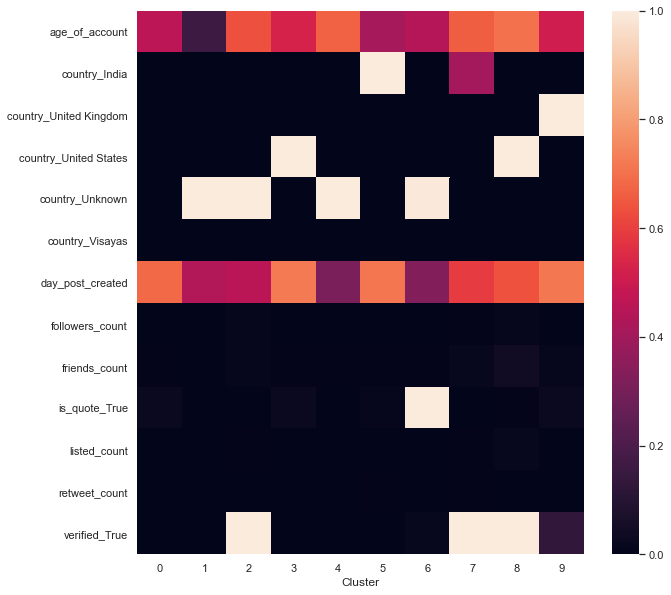

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cluster_summary2.transpose(), annot=False)

# EDA

## Country

In [130]:
countries = data[['country', 'text', 'user_id']].drop_duplicates('user_id')

In [131]:
from nltk.probability import FreqDist

fdist_country = FreqDist()

for country in countries['country']:
    fdist_country[country]+=1
fdist_country

FreqDist({'Unknown': 1204, 'United States': 1120, 'United Kingdom': 369, 'India': 160, 'Canada': 111, 'Australia': 66, 'Global': 62, 'Nigeria': 42, 'South Africa': 28, 'Deutschland': 25, ...})

In [132]:
fdist_country.most_common(20)

[('Unknown', 1204),
 ('United States', 1120),
 ('United Kingdom', 369),
 ('India', 160),
 ('Canada', 111),
 ('Australia', 66),
 ('Global', 62),
 ('Nigeria', 42),
 ('South Africa', 28),
 ('Deutschland', 25),
 ('France', 22),
 ('الإمارات العربية المتحدة', 21),
 ('Kenya', 20),
 ('Éire / Ireland', 19),
 ('Nederland', 17),
 ('中国', 14),
 ('België / Belgique / Belgien', 13),
 ('پاکستان', 12),
 ('Brasil', 12),
 ('Colombia', 11)]

In [142]:
 #however, this does not mean "China" in Chinese. It't not even a place

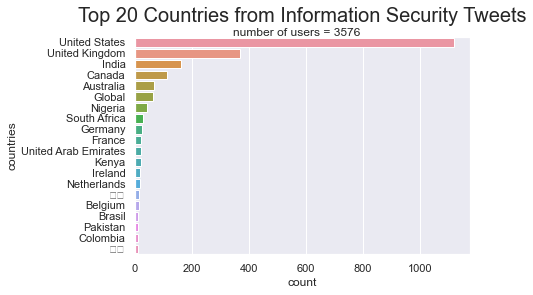

In [143]:
del fdist_country['Unknown'] #there are too much unknown users that skewed the chart
freq_data_country = pd.DataFrame.from_dict(fdist_country.most_common(20))
sns.barplot(data = freq_data_country, x = 1, y = 0)
plt.title("Top 20 Countries from Information Security Tweets", size = 20, y = 1.04)
plt.suptitle("number of users = 3576", y = 0.91)
plt.xlabel("count")
plt.ylabel("countries");

In [144]:
fdist_country.most_common(20)

[('United States', 1120),
 ('United Kingdom', 369),
 ('India', 160),
 ('Canada', 111),
 ('Australia', 66),
 ('Global', 62),
 ('Nigeria', 42),
 ('South Africa', 28),
 ('Germany', 25),
 ('France', 22),
 ('United Arab Emirates', 21),
 ('Kenya', 20),
 ('Ireland', 19),
 ('Netherlands', 17),
 ('中国', 14),
 ('Belgium', 13),
 ('Brasil', 12),
 ('Pakistan', 12),
 ('Colombia', 11),
 ('日本', 11)]

In [145]:
fdist_country["China"] = fdist_country.pop("中国")
fdist_country["Japan"] = fdist_country.pop("日本")

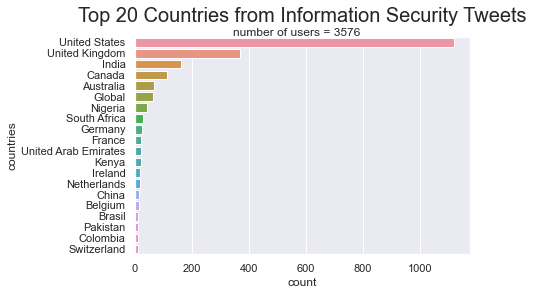

In [146]:
freq_data_country = pd.DataFrame.from_dict(fdist_country.most_common(20))
sns.barplot(data = freq_data_country, x = 1, y = 0)
plt.title("Top 20 Countries from Information Security Tweets", size = 20, y = 1.04)
plt.suptitle("number of users = 3576", y = 0.91)
plt.xlabel("count")
plt.ylabel("countries");

## Retweet

In [74]:
retweet_cnt = data[['retweet_count']].astype("float64")
retweet_cnt.head()

,retweet_count
0,1.0
1,0.0
2,0.0
3,0.0
4,2.0


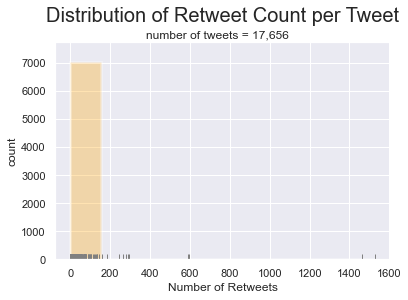

In [76]:
sns.distplot(retweet_cnt, x = retweet_cnt, kde = False, color = 'gray',  hist_kws={"linewidth": 3,
...                             "alpha": .3, "color": "orange"}, rug = True, bins = 10)
plt.title("Distribution of Retweet Count per Tweet", y = 1.065, size = 20)
plt.suptitle("number of tweets = 17,656", y = .92)
plt.xlabel("Number of Retweets")
plt.ylabel("count");

In [82]:
over5_rts = data[data.retweet_count.astype("float64") > 10][['text', 'retweet_count', "followers_count", "verified", "description"]]
over5_rts.head()

,text,retweet_count,followers_count,verified,description
5,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/6kNvALVkMP",95,4320,True,"The Union Minister for Commerce & Industry is the President of the NPC, and the Secretary, Department for Promotion of Industry & Internal Trade is Chairman."
6,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/WTQozlnikP",78,4320,True,"The Union Minister for Commerce & Industry is the President of the NPC, and the Secretary, Department for Promotion of Industry & Internal Trade is Chairman."
7,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/INEp4YGqnQ",59,4320,True,"The Union Minister for Commerce & Industry is the President of the NPC, and the Secretary, Department for Promotion of Industry & Internal Trade is Chairman."
8,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/a3VILrO09s",45,4320,True,"The Union Minister for Commerce & Industry is the President of the NPC, and the Secretary, Department for Promotion of Industry & Internal Trade is Chairman."
9,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/pGvHzLnn8S",66,4320,True,"The Union Minister for Commerce & Industry is the President of the NPC, and the Secretary, Department for Promotion of Industry & Internal Trade is Chairman."


In [86]:
over5_rts['text'] = over5_rts['text'].apply(cleanTxt)
over5_rts['text'] = over5_rts['text'].apply(stopWords)
over5_rts.head()

,text,retweet_count,followers_count,verified,description
5,join npcindiagov webinar manual preparation document iso 270012013 management systemdate time 19062021 0330 pm 0500 pmto register,95,4320,True,"The Union Minister for Commerce & Industry is the President of the NPC, and the Secretary, Department for Promotion of Industry & Internal Trade is Chairman."
6,join npcindiagov webinar manual preparation document iso 270012013 management systemdate time 19062021 0330 pm 0500 pmto register,78,4320,True,"The Union Minister for Commerce & Industry is the President of the NPC, and the Secretary, Department for Promotion of Industry & Internal Trade is Chairman."
7,join npcindiagov webinar manual preparation document iso 270012013 management systemdate time 19062021 0330 pm 0500 pmto register,59,4320,True,"The Union Minister for Commerce & Industry is the President of the NPC, and the Secretary, Department for Promotion of Industry & Internal Trade is Chairman."
8,join npcindiagov webinar manual preparation document iso 270012013 management systemdate time 19062021 0330 pm 0500 pmto register,45,4320,True,"The Union Minister for Commerce & Industry is the President of the NPC, and the Secretary, Department for Promotion of Industry & Internal Trade is Chairman."
9,join npcindiagov webinar manual preparation document iso 270012013 management systemdate time 19062021 0330 pm 0500 pmto register,66,4320,True,"The Union Minister for Commerce & Industry is the President of the NPC, and the Secretary, Department for Promotion of Industry & Internal Trade is Chairman."


In [87]:
rts_words = []

for row in over5_rts['text']:
    for word in str(row).split(" "):
        rts_words.append(word)
        
rts_words[:5]

['join', 'npcindiagov', 'webinar', 'manual', 'preparation']

In [88]:
fdist_over5 = FreqDist()
for word in rts_words:
    fdist_over5[word]+=1
fdist_over5

FreqDist({'management': 58, 'join': 56, 'pm': 56, 'npcindiagov': 52, 'webinar': 52, 'manual': 52, 'preparation': 52, 'document': 52, 'iso': 52, '270012013': 52, ...})

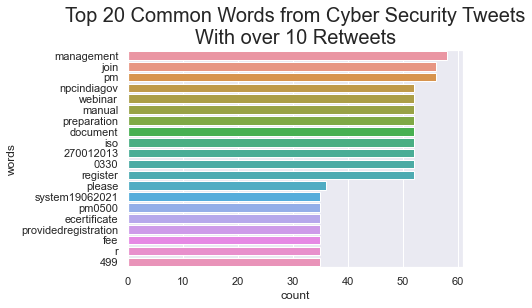

In [89]:
freq_data_over5 = pd.DataFrame.from_dict(fdist_over5.most_common(20))
sns.barplot(data = freq_data_over5, x = 1, y = 0)
plt.title("Top 20 Common Words from Cyber Security Tweets" + "\n" + "With over 10 Retweets", size = 20)
#plt.suptitle("With over 10 Retweets", y = .9)
plt.xlabel("count")
plt.ylabel("words");


## Follower Count

In [90]:
followers = data[['followers_count', 'user_id']].drop_duplicates('user_id')
followers.head()

,followers_count,user_id
0,10760,x1030495583759478784
1,547,x826314436755517441
2,868,x24552048
3,12,x1279673714603429888
4,4320,x3283206152


In [91]:
followers["new_fol_col"] = followers["followers_count"].astype("float64")
followers.head()

,followers_count,user_id,new_fol_col
0,10760,x1030495583759478784,10760.0
1,547,x826314436755517441,547.0
2,868,x24552048,868.0
3,12,x1279673714603429888,12.0
4,4320,x3283206152,4320.0


In [92]:
mean_fol = followers['followers_count'].astype('float64').mean()

In [93]:
followers['diff_from_mean'] = followers['new_fol_col'] - mean_fol

In [94]:
followers.shape

(4840, 4)

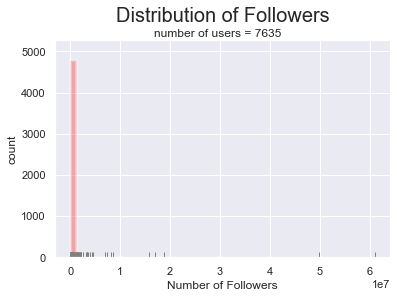

In [95]:
sns.distplot(followers['new_fol_col'], norm_hist = False, kde = False, rug = True, color = "gray",
            hist_kws={"linewidth": 3, "color": "red", "alpha": .3, "range": (0, 10500000)},
            bins = 10)
plt.title("Distribution of Followers", y = 1.055, size = 20)
plt.suptitle("number of users = 7635", y = .92);
plt.xlabel("Number of Followers")
plt.ylabel("count");

In [96]:
followers['diff_from_mean'].min()

-66662.91508264463

In [97]:
followers['diff_from_mean'].max()

60949709.08491736

In [98]:
followers['followers_count'].astype('float64').max()

61016372.0

## Hashtags

In [147]:
hashs = data[["hashtags"]].dropna()
hashs

,hashtags
1,healthcare Cybersecurity
4,npcindia
5,npcindia
6,npcindia
7,npcindia
...,...
7217,dontfencethecapitol
7220,podcasts Podcast Security CyberSecurity InfoSec InfoSecurity WomenInSec
7224,Microsoft365
7225,ransomware regulation cybersecurity


In [148]:
def removeInfosec(txt):
    txt_lst = txt.lower().split()
    if "information security" in txt_lst:
        txt_lst.remove("information security")
    return " ".join(txt_lst)

In [149]:
hashs['hashtags'] = hashs['hashtags'].apply(removeInfosec)

In [150]:
hashs.head()

,hashtags
1,healthcare cybersecurity
4,npcindia
5,npcindia
6,npcindia
7,npcindia


In [151]:
hash_words = []

for row in hashs['hashtags']:
    for word in str(row).split(" "):
        hash_words.append(word)
        
hash_words[:5]

['healthcare', 'cybersecurity', 'npcindia', 'npcindia', 'npcindia']

In [152]:
hash_words = [word for word in hash_words if word != '']

In [153]:
fdist_hash = FreqDist()
for word in hash_words:
    fdist_hash[word]+=1
fdist_hash

FreqDist({'cybersecurity': 496, 'security': 357, 'infosec': 170, 'isdots': 71, 'informationsecurity': 56, 'privacy': 48, 'quickbookspartner': 47, 'siem': 43, 'technology': 42, 'jobs': 41, ...})

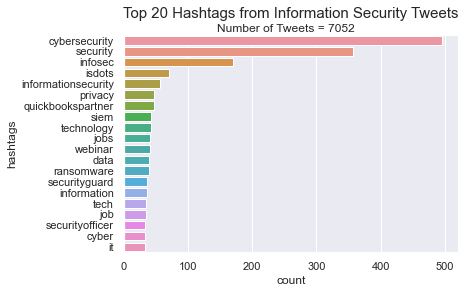

In [154]:
freq_data_hash = pd.DataFrame.from_dict(fdist_hash.most_common(20))
sns.barplot(data = freq_data_hash, x = 1, y = 0)
plt.title("Top 20 Hashtags from Information Security Tweets", size = 15, y = 1.05)
plt.suptitle("Number of Tweets = 7052", y = .92)
plt.xlabel("count")
plt.ylabel("hashtags");


## Year

In [155]:
acc_created = data[['year_account_created', 'text']]
acc_created.head()

,year_account_created,text
0,2018.0,"Priti Patel’s new threat to British journalists \r\n\r\nBloody hell she’s at it again; change to Secrecy Laws, journalists and others in jail for 14 years for publishing information the government claims damages national security. Authoritarianism https://t.co/2heTpFNi4l"
1,2017.0,"As #healthcare organizations continue to greatly depend on the flow of information to better support patient care, they must establish better security practices. This is where the secure access service edge (SASE) model comes in. #Cybersecurity https://t.co/X9VE9zmNUb"
2,2009.0,"“In the next 10 years, FHE could even help researchers find associations between specific gene mutations by analyzing genetic information across thousands of encrypted samples."" https://t.co/3szQeo15Us"
3,2020.0,@JoyNewsOnTV The police must review their SOPs and do a corrective action and preventive action to address this national security issues. We have cameras all over but are they working? Information gathering and all. How long are we going to sit down. What is the plan?
4,2015.0,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/Jb5gVzDcUy"


In [156]:
acc_created['text'] = acc_created['text'].apply(cleanTxt)
acc_created['text'] = acc_created['text'].apply(stopWords)
acc_created.head()

AttributeError: 'float' object has no attribute 'lower'

In [157]:
from datetime import datetime
data['created_at'] = data[["created_at"]].apply(pd.to_datetime)
data['created_at'] = data['created_at'].apply(datetime.date)
data[['created_at']]

,created_at
0,2021-06-16
1,2021-06-16
2,2021-06-16
3,2021-06-16
4,2021-06-16
...,...
7222,2021-06-08
7223,2021-06-08
7224,2021-06-08
7225,2021-06-08


In [158]:
acc_created['year_account_created'] = acc_created['year_account_created'].astype(str).astype(int)
acc_created['age_of_account'] = 2021 - acc_created['year_account_created']
acc_created.head()

ValueError: invalid literal for int() with base 10: '2018.0'

In [ ]:
sns.distplot(acc_created['age_of_account'],  kde = False, bins =15)
plt.title("Age of Twitter Account (years)", size = 20, y = 1.06)
plt.suptitle("number of users = 3576", y = .925)
plt.xlabel("Age of Account")
plt.ylabel("count");

## Sentiment Analysis based on locations

In [197]:
usa = data[data.country == "United States"][['country', 'text', 'user_id']]
usa.head()

,country,text,user_id
1,United States,"As #healthcare organizations continue to greatly depend on the flow of information to better support patient care, they must establish better security practices. This is where the secure access service edge (SASE) model comes in. #Cybersecurity https://t.co/X9VE9zmNUb",x826314436755517441
24,United States,"Here is the 1st segment of our newest 3-part blog series around alignment between the business &amp; #infosec, based on research &amp; data we've compiled: https://t.co/339yH9j38o. \r\n\r\nThis blog showcases one portion of the findings from our new #ebook. To download: https://t.co/NrJUFEu8DO https://t.co/sIoUW4IhZJ",x1347244711254355970
25,United States,@ATTBusiness A2-3: Having a trusted partner is also crucial. \r\n\r\nHere is an interesting story from @permarsec – and how they worked with #ATT #Cybersecurity solutions to help safeguard their IT networks and confidential client information.\r\n\r\n#ATTInfluencer @ATTBusiness \r\n\r\nhttps://t.co/eMey6TU1sk,x2908107542
26,United States,"@ATTBusiness A2: …Also, keep in mind that deploying advanced #cybersecurity technologies without first implementing strong foundational information security practices is like building a fort on quicksand.\r\n\r\n#BizTalks #ATTInfluencer #InfoSec #Security #Ransomware https://t.co/sUDy3K4Tix",x33669105
27,United States,@Salem4Congress @darockreaper @StinkRatStreams @mattbc OK but not everyone with chronic health issues understands fully health information Security how that actually affect disabled people's life my dude. That's what Matt was pointing out.,x2484510337


In [198]:
sid = SentimentIntensityAnalyzer()
usa['scores'] = usa['text'].apply(lambda review: sid.polarity_scores(str(review)))
usa['compound']  = usa['scores'].apply(lambda score_dict: score_dict['compound'])
usa['comp_score'] = usa['compound'].apply(lambda c: 'pos' if c >=0.05 else ('neg' if c <= -0.05 else 'neutral'))
usa.head()

,country,text,user_id,scores,compound,comp_score
1,United States,"As #healthcare organizations continue to greatly depend on the flow of information to better support patient care, they must establish better security practices. This is where the secure access service edge (SASE) model comes in. #Cybersecurity https://t.co/X9VE9zmNUb",x826314436755517441,"{'neg': 0.0, 'neu': 0.653, 'pos': 0.347, 'compound': 0.9382}",0.9382,pos
24,United States,"Here is the 1st segment of our newest 3-part blog series around alignment between the business &amp; #infosec, based on research &amp; data we've compiled: https://t.co/339yH9j38o. \r\n\r\nThis blog showcases one portion of the findings from our new #ebook. To download: https://t.co/NrJUFEu8DO https://t.co/sIoUW4IhZJ",x1347244711254355970,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral
25,United States,@ATTBusiness A2-3: Having a trusted partner is also crucial. \r\n\r\nHere is an interesting story from @permarsec – and how they worked with #ATT #Cybersecurity solutions to help safeguard their IT networks and confidential client information.\r\n\r\n#ATTInfluencer @ATTBusiness \r\n\r\nhttps://t.co/eMey6TU1sk,x2908107542,"{'neg': 0.0, 'neu': 0.721, 'pos': 0.279, 'compound': 0.8957}",0.8957,pos
26,United States,"@ATTBusiness A2: …Also, keep in mind that deploying advanced #cybersecurity technologies without first implementing strong foundational information security practices is like building a fort on quicksand.\r\n\r\n#BizTalks #ATTInfluencer #InfoSec #Security #Ransomware https://t.co/sUDy3K4Tix",x33669105,"{'neg': 0.069, 'neu': 0.692, 'pos': 0.238, 'compound': 0.6806}",0.6806,pos
27,United States,@Salem4Congress @darockreaper @StinkRatStreams @mattbc OK but not everyone with chronic health issues understands fully health information Security how that actually affect disabled people's life my dude. That's what Matt was pointing out.,x2484510337,"{'neg': 0.0, 'neu': 0.846, 'pos': 0.154, 'compound': 0.6664}",0.6664,pos


In [191]:
colours = {'pos': 'salmon',
           'neg': 'darkgray',
           'neutral': 'teal'}
labels = ['pos', 'neutral', 'neg']

Text(0, 0.56, 'compound score')

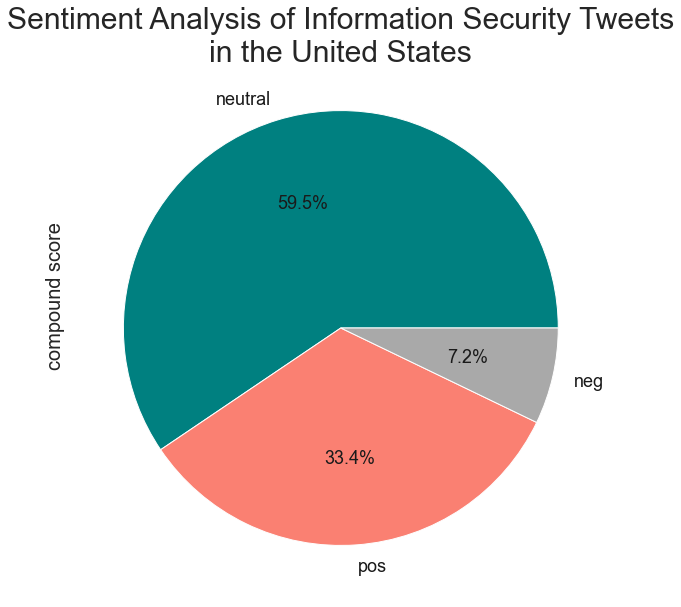

In [211]:
fig, ax = plt.subplots(figsize=(15,10))
comp_score_counts_usa = usa.comp_score.value_counts()
comp_score_counts_usa.plot.pie(autopct="%.1f%%", colors=['teal', 'salmon','darkgray'], textprops={'fontsize': 18, "color": "k"})
plt.title("Sentiment Analysis of Information Security Tweets" + "\n" + "in the United States", size = 30, y = .98)
plt.ylabel("compound score", size = 20, y = .56)

In [206]:
uk = data[data.country == "United Kingdom"][['country', 'text', 'user_id']]
uk.head()

,country,text,user_id
0,United Kingdom,"Priti Patel’s new threat to British journalists \r\n\r\nBloody hell she’s at it again; change to Secrecy Laws, journalists and others in jail for 14 years for publishing information the government claims damages national security. Authoritarianism https://t.co/2heTpFNi4l",x1030495583759478784
262,United Kingdom,"whom to show their weapons but hamas refused while abbas wants his apply segmant of talk to assure the securty define , abbas should know that this security fail agreement with israel whom he trying to give information inside hamas and qassam and through other coutnries",x127485899
263,United Kingdom,"first you depend only in most of the cases over the public lab system whom are not prepared enough , and second there is problem in receiving and contacting information for what type of the diseases what clls differences and gap in knowledge , and third countries security reasons",x127485899
267,United Kingdom,Janus Henderson Investors Information Security team is looking for someone to join their team as an apprentice. The apprenticeship is a 24 month fixed term contract.\r\n\r\nApply: https://t.co/X71RO1AtWX https://t.co/Sy1sZzZIv4,x2151196880
268,United Kingdom,Are you interested in studying an Introduction into Cyber Security training course in the #WestMidlands? Click here for further information: https://t.co/NBh0aDARJh\r\n\r\n@nationalcareers @JCPInWorcester @JCPInStaffs @JCPinBirmingham @covjobsupport https://t.co/k2RP4iKJck,x2969912506


In [207]:
sid = SentimentIntensityAnalyzer()
uk['scores'] = uk['text'].apply(lambda review: sid.polarity_scores(str(review)))
uk['compound']  = uk['scores'].apply(lambda score_dict: score_dict['compound'])
uk['comp_score'] = uk['compound'].apply(lambda c: 'pos' if c >=0.05 else ('neg' if c <= -0.05 else 'neutral'))
uk.head()

,country,text,user_id,scores,compound,comp_score
0,United Kingdom,"Priti Patel’s new threat to British journalists \r\n\r\nBloody hell she’s at it again; change to Secrecy Laws, journalists and others in jail for 14 years for publishing information the government claims damages national security. Authoritarianism https://t.co/2heTpFNi4l",x1030495583759478784,"{'neg': 0.292, 'neu': 0.657, 'pos': 0.051, 'compound': -0.9081}",-0.9081,neg
262,United Kingdom,"whom to show their weapons but hamas refused while abbas wants his apply segmant of talk to assure the securty define , abbas should know that this security fail agreement with israel whom he trying to give information inside hamas and qassam and through other coutnries",x127485899,"{'neg': 0.157, 'neu': 0.661, 'pos': 0.182, 'compound': 0.3664}",0.3664,pos
263,United Kingdom,"first you depend only in most of the cases over the public lab system whom are not prepared enough , and second there is problem in receiving and contacting information for what type of the diseases what clls differences and gap in knowledge , and third countries security reasons",x127485899,"{'neg': 0.083, 'neu': 0.872, 'pos': 0.045, 'compound': -0.242}",-0.2420,neg
267,United Kingdom,Janus Henderson Investors Information Security team is looking for someone to join their team as an apprentice. The apprenticeship is a 24 month fixed term contract.\r\n\r\nApply: https://t.co/X71RO1AtWX https://t.co/Sy1sZzZIv4,x2151196880,"{'neg': 0.0, 'neu': 0.854, 'pos': 0.146, 'compound': 0.5574}",0.5574,pos
268,United Kingdom,Are you interested in studying an Introduction into Cyber Security training course in the #WestMidlands? Click here for further information: https://t.co/NBh0aDARJh\r\n\r\n@nationalcareers @JCPInWorcester @JCPInStaffs @JCPinBirmingham @covjobsupport https://t.co/k2RP4iKJck,x2969912506,"{'neg': 0.0, 'neu': 0.831, 'pos': 0.169, 'compound': 0.6249}",0.6249,pos


Text(0, 0.5, 'compound score')

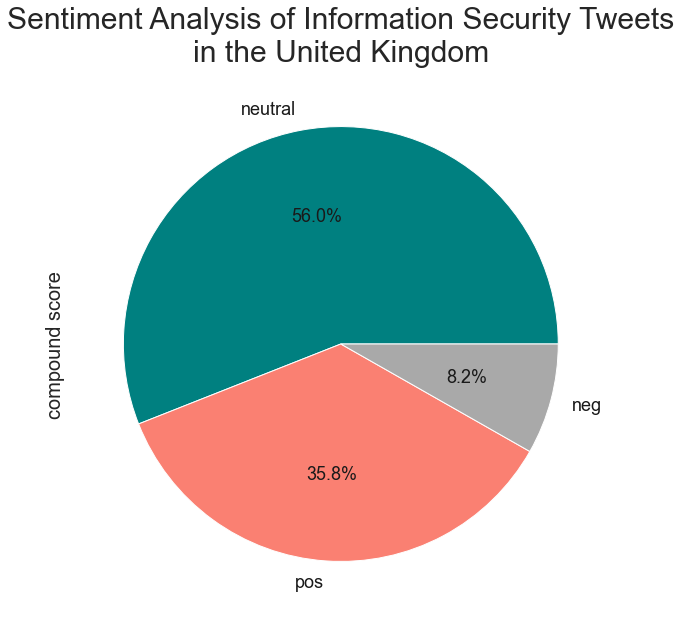

In [210]:
fig, ax = plt.subplots(figsize=(15,10))
comp_score_counts_uk = uk.comp_score.value_counts()
comp_score_counts_uk.plot.pie(autopct="%.1f%%", colors=['teal','salmon','darkgray'], textprops={'fontsize': 18, "color": "k"})
plt.title("Sentiment Analysis of Information Security Tweets" + "\n" + "in the United Kingdom", size = 30, y = 1.01)
plt.ylabel("compound score", size = 20)


In [212]:
india = data[data.country == "India"][['country', 'text', 'user_id']]
india.head()

,country,text,user_id
4,India,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/Jb5gVzDcUy",x3283206152
5,India,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/6kNvALVkMP",x3283206152
6,India,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/WTQozlnikP",x3283206152
7,India,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/INEp4YGqnQ",x3283206152
8,India,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/a3VILrO09s",x3283206152


In [213]:
india['scores'] = india['text'].apply(lambda review: sid.polarity_scores(str(review)))
india['compound']  = india['scores'].apply(lambda score_dict: score_dict['compound'])
india['comp_score'] = india['compound'].apply(lambda c: 'pos' if c >=0.05 else ('neg' if c <= -0.05 else 'neutral'))
india.head()

,country,text,user_id,scores,compound,comp_score
4,India,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/Jb5gVzDcUy",x3283206152,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'compound': 0.5574}",0.5574,pos
5,India,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/6kNvALVkMP",x3283206152,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'compound': 0.5574}",0.5574,pos
6,India,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/WTQozlnikP",x3283206152,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'compound': 0.5574}",0.5574,pos
7,India,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/INEp4YGqnQ",x3283206152,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'compound': 0.5574}",0.5574,pos
8,India,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/a3VILrO09s",x3283206152,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'compound': 0.5574}",0.5574,pos


In [214]:
colours = {'pos': 'salmon',
           'neutral': 'darkgray',
           'neg': 'teal'}
labels = ['neutral', 'pos', 'neg']

Text(0, 0.5, 'compound score')

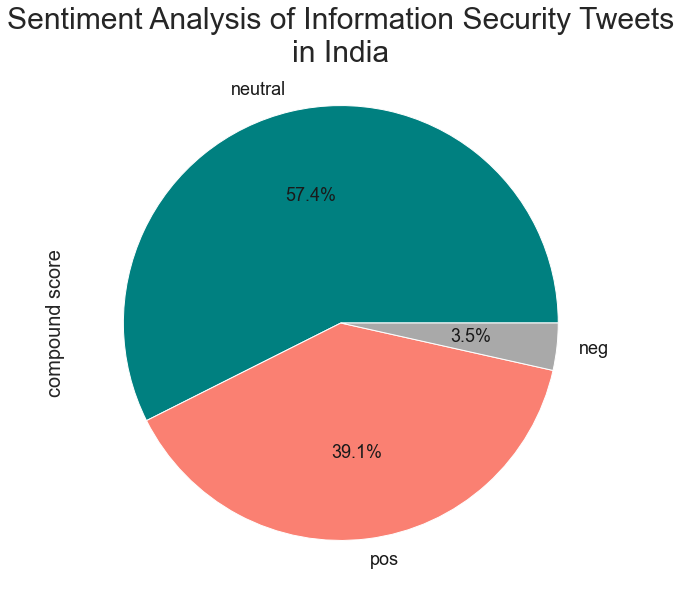

In [216]:
fig, ax = plt.subplots(figsize=(15,10))
comp_score_counts_india = india.comp_score.value_counts()
comp_score_counts_india.plot.pie(autopct="%.1f%%", colors=["teal",'salmon','darkgray'], textprops={'fontsize': 18, "color": "k"})
plt.title("Sentiment Analysis of Information Security Tweets" + "\n" + "in India", size = 30, y = .97)
plt.ylabel("compound score", size = 20)

# World Map

In [217]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)}) 

import warnings
warnings.simplefilter("ignore")

%matplotlib inline 

from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import SCORERS
import re

import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [226]:
from googletrans import Translator, constants
from pprint import pprint
!pip install google-trans-new
from google_trans_new import google_translator

In [227]:
!pip install googletrans==3.1.0a0

In [228]:
translator = Translator()  
def googTrans(txt):
    try:
        translation = translator.translate(txt,lang_tgt='en')
        return translation.text
    except:
        return txt

In [229]:
def get_continent_Code(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return cn_a2_code

def get_continent_Cont(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return cn_continent

In [230]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = "my_application")
def geolocate_Lat(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return loc.latitude
    except:
        # Return missing value
        return np.nan
    
def geolocate_Long(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return loc.longitude
    except:
        # Return missing value
        return np.nan

In [242]:
data_cyber = pd.read_csv("data/data1.csv").drop('Unnamed: 0', axis = 1)
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,day_post_created,age_of_account,year_account_created
0,x1030495583759478784,x1405214456762847240,2021-06-16,up_again,"Priti Patel’s new threat to British journalists \r\n\r\nBloody hell she’s at it again; change to Secrecy Laws, journalists and others in jail for 14 years for publishing information the government claims damages national security. Authoritarianism https://t.co/2heTpFNi4l",Twitter for iPhone,266.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/1030495583759478784/1620936248,NaN,http://pbs.twimg.com/profile_images/1397433079958999040/rbuxUQO8_normal.jpg,16.0,NaN,2018.0
1,x826314436755517441,x1405213833359249409,2021-06-16,Cassi__Chandler,"As #healthcare organizations continue to greatly depend on the flow of information to better support patient care, they must establish better security practices. This is where the secure access service edge (SASE) model comes in. #Cybersecurity https://t.co/X9VE9zmNUb",Qnary.io,268.0,NaN,NaN,NaN,...,False,https://t.co/YKq9rHQYw3,https://www.linkedin.com/in/cassichandler/,NaN,https://pbs.twimg.com/profile_banners/826314436755517441/1615308619,NaN,http://pbs.twimg.com/profile_images/826315750415675392/WBucEA0l_normal.jpg,16.0,NaN,2017.0
2,x24552048,x1405213670653693952,2021-06-16,jsargey,"“In the next 10 years, FHE could even help researchers find associations between specific gene mutations by analyzing genetic information across thousands of encrypted samples."" https://t.co/3szQeo15Us",Twitter Web App,201.0,NaN,NaN,NaN,...,False,https://t.co/3RVlHQQU1N,http://jennasargent.contently.com,NaN,https://pbs.twimg.com/profile_banners/24552048/1594407914,http://abs.twimg.com/images/themes/theme5/bg.gif,http://pbs.twimg.com/profile_images/1270890100570968065/md55-y1W_normal.jpg,16.0,NaN,2009.0
3,x1279673714603429888,x1405213608880099335,2021-06-16,Manfrida4,@JoyNewsOnTV The police must review their SOPs and do a corrective action and preventive action to address this national security issues. We have cameras all over but are they working? Information gathering and all. How long are we going to sit down. What is the plan?,Twitter Web App,255.0,x1405188710887477249,x610124383,JoyNewsOnTV,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/1279673714603429888/1622378495,NaN,http://pbs.twimg.com/profile_images/1279676445300834305/BBSmJ3rV_normal.jpg,16.0,NaN,2020.0
4,x3283206152,x1405213605734256646,2021-06-16,NPC_INDIA_GOV,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/Jb5gVzDcUy",Hootsuite Inc.,279.0,NaN,NaN,NaN,...,True,https://t.co/h1j0UFKiph,http://www.npcindia.gov.in,NaN,https://pbs.twimg.com/profile_banners/3283206152/1451633754,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/672316907832262656/2rfTs3tS_normal.jpg,16.0,NaN,2015.0


In [247]:
countries_cyber = data_cyber[['country']]

In [248]:
data_privacy = pd.read_csv("data/data4.csv").drop('Unnamed: 0', axis = 1)
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,day_post_created,age_of_account,year_account_created
0,x1030495583759478784,x1405214456762847240,2021-06-16,up_again,"Priti Patel’s new threat to British journalists \r\n\r\nBloody hell she’s at it again; change to Secrecy Laws, journalists and others in jail for 14 years for publishing information the government claims damages national security. Authoritarianism https://t.co/2heTpFNi4l",Twitter for iPhone,266.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/1030495583759478784/1620936248,NaN,http://pbs.twimg.com/profile_images/1397433079958999040/rbuxUQO8_normal.jpg,16.0,NaN,2018.0
1,x826314436755517441,x1405213833359249409,2021-06-16,Cassi__Chandler,"As #healthcare organizations continue to greatly depend on the flow of information to better support patient care, they must establish better security practices. This is where the secure access service edge (SASE) model comes in. #Cybersecurity https://t.co/X9VE9zmNUb",Qnary.io,268.0,NaN,NaN,NaN,...,False,https://t.co/YKq9rHQYw3,https://www.linkedin.com/in/cassichandler/,NaN,https://pbs.twimg.com/profile_banners/826314436755517441/1615308619,NaN,http://pbs.twimg.com/profile_images/826315750415675392/WBucEA0l_normal.jpg,16.0,NaN,2017.0
2,x24552048,x1405213670653693952,2021-06-16,jsargey,"“In the next 10 years, FHE could even help researchers find associations between specific gene mutations by analyzing genetic information across thousands of encrypted samples."" https://t.co/3szQeo15Us",Twitter Web App,201.0,NaN,NaN,NaN,...,False,https://t.co/3RVlHQQU1N,http://jennasargent.contently.com,NaN,https://pbs.twimg.com/profile_banners/24552048/1594407914,http://abs.twimg.com/images/themes/theme5/bg.gif,http://pbs.twimg.com/profile_images/1270890100570968065/md55-y1W_normal.jpg,16.0,NaN,2009.0
3,x1279673714603429888,x1405213608880099335,2021-06-16,Manfrida4,@JoyNewsOnTV The police must review their SOPs and do a corrective action and preventive action to address this national security issues. We have cameras all over but are they working? Information gathering and all. How long are we going to sit down. What is the plan?,Twitter Web App,255.0,x1405188710887477249,x610124383,JoyNewsOnTV,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/1279673714603429888/1622378495,NaN,http://pbs.twimg.com/profile_images/1279676445300834305/BBSmJ3rV_normal.jpg,16.0,NaN,2020.0
4,x3283206152,x1405213605734256646,2021-06-16,NPC_INDIA_GOV,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/Jb5gVzDcUy",Hootsuite Inc.,279.0,NaN,NaN,NaN,...,True,https://t.co/h1j0UFKiph,http://www.npcindia.gov.in,NaN,https://pbs.twimg.com/profile_banners/3283206152/1451633754,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/672316907832262656/2rfTs3tS_normal.jpg,16.0,NaN,2015.0


In [249]:
countries_privacy = data_privacy[['country']]

In [250]:
data_infosec = pd.read_csv("data/data5.csv").drop('Unnamed: 0', axis = 1)
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,day_post_created,age_of_account,year_account_created
0,x1030495583759478784,x1405214456762847240,2021-06-16,up_again,"Priti Patel’s new threat to British journalists \r\n\r\nBloody hell she’s at it again; change to Secrecy Laws, journalists and others in jail for 14 years for publishing information the government claims damages national security. Authoritarianism https://t.co/2heTpFNi4l",Twitter for iPhone,266.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/1030495583759478784/1620936248,NaN,http://pbs.twimg.com/profile_images/1397433079958999040/rbuxUQO8_normal.jpg,16.0,NaN,2018.0
1,x826314436755517441,x1405213833359249409,2021-06-16,Cassi__Chandler,"As #healthcare organizations continue to greatly depend on the flow of information to better support patient care, they must establish better security practices. This is where the secure access service edge (SASE) model comes in. #Cybersecurity https://t.co/X9VE9zmNUb",Qnary.io,268.0,NaN,NaN,NaN,...,False,https://t.co/YKq9rHQYw3,https://www.linkedin.com/in/cassichandler/,NaN,https://pbs.twimg.com/profile_banners/826314436755517441/1615308619,NaN,http://pbs.twimg.com/profile_images/826315750415675392/WBucEA0l_normal.jpg,16.0,NaN,2017.0
2,x24552048,x1405213670653693952,2021-06-16,jsargey,"“In the next 10 years, FHE could even help researchers find associations between specific gene mutations by analyzing genetic information across thousands of encrypted samples."" https://t.co/3szQeo15Us",Twitter Web App,201.0,NaN,NaN,NaN,...,False,https://t.co/3RVlHQQU1N,http://jennasargent.contently.com,NaN,https://pbs.twimg.com/profile_banners/24552048/1594407914,http://abs.twimg.com/images/themes/theme5/bg.gif,http://pbs.twimg.com/profile_images/1270890100570968065/md55-y1W_normal.jpg,16.0,NaN,2009.0
3,x1279673714603429888,x1405213608880099335,2021-06-16,Manfrida4,@JoyNewsOnTV The police must review their SOPs and do a corrective action and preventive action to address this national security issues. We have cameras all over but are they working? Information gathering and all. How long are we going to sit down. What is the plan?,Twitter Web App,255.0,x1405188710887477249,x610124383,JoyNewsOnTV,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/1279673714603429888/1622378495,NaN,http://pbs.twimg.com/profile_images/1279676445300834305/BBSmJ3rV_normal.jpg,16.0,NaN,2020.0
4,x3283206152,x1405213605734256646,2021-06-16,NPC_INDIA_GOV,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/Jb5gVzDcUy",Hootsuite Inc.,279.0,NaN,NaN,NaN,...,True,https://t.co/h1j0UFKiph,http://www.npcindia.gov.in,NaN,https://pbs.twimg.com/profile_banners/3283206152/1451633754,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/672316907832262656/2rfTs3tS_normal.jpg,16.0,NaN,2015.0


In [251]:
countries_infosec = data_infosec[['country']]

In [256]:
data_ethics = pd.read_csv("data/data2.csv")
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,day_post_created,age_of_account,year_account_created
0,x1030495583759478784,x1405214456762847240,2021-06-16,up_again,"Priti Patel’s new threat to British journalists \r\n\r\nBloody hell she’s at it again; change to Secrecy Laws, journalists and others in jail for 14 years for publishing information the government claims damages national security. Authoritarianism https://t.co/2heTpFNi4l",Twitter for iPhone,266.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/1030495583759478784/1620936248,NaN,http://pbs.twimg.com/profile_images/1397433079958999040/rbuxUQO8_normal.jpg,16.0,NaN,2018.0
1,x826314436755517441,x1405213833359249409,2021-06-16,Cassi__Chandler,"As #healthcare organizations continue to greatly depend on the flow of information to better support patient care, they must establish better security practices. This is where the secure access service edge (SASE) model comes in. #Cybersecurity https://t.co/X9VE9zmNUb",Qnary.io,268.0,NaN,NaN,NaN,...,False,https://t.co/YKq9rHQYw3,https://www.linkedin.com/in/cassichandler/,NaN,https://pbs.twimg.com/profile_banners/826314436755517441/1615308619,NaN,http://pbs.twimg.com/profile_images/826315750415675392/WBucEA0l_normal.jpg,16.0,NaN,2017.0
2,x24552048,x1405213670653693952,2021-06-16,jsargey,"“In the next 10 years, FHE could even help researchers find associations between specific gene mutations by analyzing genetic information across thousands of encrypted samples."" https://t.co/3szQeo15Us",Twitter Web App,201.0,NaN,NaN,NaN,...,False,https://t.co/3RVlHQQU1N,http://jennasargent.contently.com,NaN,https://pbs.twimg.com/profile_banners/24552048/1594407914,http://abs.twimg.com/images/themes/theme5/bg.gif,http://pbs.twimg.com/profile_images/1270890100570968065/md55-y1W_normal.jpg,16.0,NaN,2009.0
3,x1279673714603429888,x1405213608880099335,2021-06-16,Manfrida4,@JoyNewsOnTV The police must review their SOPs and do a corrective action and preventive action to address this national security issues. We have cameras all over but are they working? Information gathering and all. How long are we going to sit down. What is the plan?,Twitter Web App,255.0,x1405188710887477249,x610124383,JoyNewsOnTV,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/1279673714603429888/1622378495,NaN,http://pbs.twimg.com/profile_images/1279676445300834305/BBSmJ3rV_normal.jpg,16.0,NaN,2020.0
4,x3283206152,x1405213605734256646,2021-06-16,NPC_INDIA_GOV,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/Jb5gVzDcUy",Hootsuite Inc.,279.0,NaN,NaN,NaN,...,True,https://t.co/h1j0UFKiph,http://www.npcindia.gov.in,NaN,https://pbs.twimg.com/profile_banners/3283206152/1451633754,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/672316907832262656/2rfTs3tS_normal.jpg,16.0,NaN,2015.0


In [257]:
countries_ethics = data_ethics[['country']]

In [258]:
data_surv = pd.read_csv("data/data3.csv")
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,day_post_created,age_of_account,year_account_created
0,x1030495583759478784,x1405214456762847240,2021-06-16,up_again,"Priti Patel’s new threat to British journalists \r\n\r\nBloody hell she’s at it again; change to Secrecy Laws, journalists and others in jail for 14 years for publishing information the government claims damages national security. Authoritarianism https://t.co/2heTpFNi4l",Twitter for iPhone,266.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/1030495583759478784/1620936248,NaN,http://pbs.twimg.com/profile_images/1397433079958999040/rbuxUQO8_normal.jpg,16.0,NaN,2018.0
1,x826314436755517441,x1405213833359249409,2021-06-16,Cassi__Chandler,"As #healthcare organizations continue to greatly depend on the flow of information to better support patient care, they must establish better security practices. This is where the secure access service edge (SASE) model comes in. #Cybersecurity https://t.co/X9VE9zmNUb",Qnary.io,268.0,NaN,NaN,NaN,...,False,https://t.co/YKq9rHQYw3,https://www.linkedin.com/in/cassichandler/,NaN,https://pbs.twimg.com/profile_banners/826314436755517441/1615308619,NaN,http://pbs.twimg.com/profile_images/826315750415675392/WBucEA0l_normal.jpg,16.0,NaN,2017.0
2,x24552048,x1405213670653693952,2021-06-16,jsargey,"“In the next 10 years, FHE could even help researchers find associations between specific gene mutations by analyzing genetic information across thousands of encrypted samples."" https://t.co/3szQeo15Us",Twitter Web App,201.0,NaN,NaN,NaN,...,False,https://t.co/3RVlHQQU1N,http://jennasargent.contently.com,NaN,https://pbs.twimg.com/profile_banners/24552048/1594407914,http://abs.twimg.com/images/themes/theme5/bg.gif,http://pbs.twimg.com/profile_images/1270890100570968065/md55-y1W_normal.jpg,16.0,NaN,2009.0
3,x1279673714603429888,x1405213608880099335,2021-06-16,Manfrida4,@JoyNewsOnTV The police must review their SOPs and do a corrective action and preventive action to address this national security issues. We have cameras all over but are they working? Information gathering and all. How long are we going to sit down. What is the plan?,Twitter Web App,255.0,x1405188710887477249,x610124383,JoyNewsOnTV,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/1279673714603429888/1622378495,NaN,http://pbs.twimg.com/profile_images/1279676445300834305/BBSmJ3rV_normal.jpg,16.0,NaN,2020.0
4,x3283206152,x1405213605734256646,2021-06-16,NPC_INDIA_GOV,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/Jb5gVzDcUy",Hootsuite Inc.,279.0,NaN,NaN,NaN,...,True,https://t.co/h1j0UFKiph,http://www.npcindia.gov.in,NaN,https://pbs.twimg.com/profile_banners/3283206152/1451633754,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/672316907832262656/2rfTs3tS_normal.jpg,16.0,NaN,2015.0


In [259]:
countries_surv = data_surv[['country']]

In [293]:
countries = pd.concat([countries_cyber,countries_privacy,countries_infosec, countries_ethics, countries_surv])

In [294]:
countries.head()

,country
0,United States
1,United States
2,United States
3,United States
4,United States


### Just infosec

In [267]:
data = pd.read_csv("data/data5.csv").drop('Unnamed: 0', axis = 1)
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,day_post_created,age_of_account,year_account_created
0,x1030495583759478784,x1405214456762847240,2021-06-16 17:23:28,up_again,"Priti Patel’s new threat to British journalists \r\n\r\nBloody hell she’s at it again; change to Secrecy Laws, journalists and others in jail for 14 years for publishing information the government claims damages national security. Authoritarianism https://t.co/2heTpFNi4l",Twitter for iPhone,266.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/1030495583759478784/1620936248,NaN,http://pbs.twimg.com/profile_images/1397433079958999040/rbuxUQO8_normal.jpg,16.0,NaN,2018.0
1,x826314436755517441,x1405213833359249409,2021-06-16 17:21:00,Cassi__Chandler,"As #healthcare organizations continue to greatly depend on the flow of information to better support patient care, they must establish better security practices. This is where the secure access service edge (SASE) model comes in. #Cybersecurity https://t.co/X9VE9zmNUb",Qnary.io,268.0,NaN,NaN,NaN,...,False,https://t.co/YKq9rHQYw3,https://www.linkedin.com/in/cassichandler/,NaN,https://pbs.twimg.com/profile_banners/826314436755517441/1615308619,NaN,http://pbs.twimg.com/profile_images/826315750415675392/WBucEA0l_normal.jpg,16.0,NaN,2017.0
2,x24552048,x1405213670653693952,2021-06-16 17:20:21,jsargey,"“In the next 10 years, FHE could even help researchers find associations between specific gene mutations by analyzing genetic information across thousands of encrypted samples."" https://t.co/3szQeo15Us",Twitter Web App,201.0,NaN,NaN,NaN,...,False,https://t.co/3RVlHQQU1N,http://jennasargent.contently.com,NaN,https://pbs.twimg.com/profile_banners/24552048/1594407914,http://abs.twimg.com/images/themes/theme5/bg.gif,http://pbs.twimg.com/profile_images/1270890100570968065/md55-y1W_normal.jpg,16.0,NaN,2009.0
3,x1279673714603429888,x1405213608880099335,2021-06-16 17:20:06,Manfrida4,@JoyNewsOnTV The police must review their SOPs and do a corrective action and preventive action to address this national security issues. We have cameras all over but are they working? Information gathering and all. How long are we going to sit down. What is the plan?,Twitter Web App,255.0,x1405188710887477249,x610124383,JoyNewsOnTV,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/1279673714603429888/1622378495,NaN,http://pbs.twimg.com/profile_images/1279676445300834305/BBSmJ3rV_normal.jpg,16.0,NaN,2020.0
4,x3283206152,x1405213605734256646,2021-06-16 17:20:05,NPC_INDIA_GOV,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/Jb5gVzDcUy",Hootsuite Inc.,279.0,NaN,NaN,NaN,...,True,https://t.co/h1j0UFKiph,http://www.npcindia.gov.in,NaN,https://pbs.twimg.com/profile_banners/3283206152/1451633754,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/672316907832262656/2rfTs3tS_normal.jpg,16.0,NaN,2015.0


In [269]:
countries = data[['country', 'text']]

In [302]:
# replacing countries for country code function
countries.country = countries.country.replace('Algérie / ⵍⵣⵣⴰⵢⴻⵔ / الجزائر', 'Algeria')
countries.country = countries.country.replace("لبنان", 'Lebanon')
countries.country = countries.country.replace("Deutschland", 'Germany')
countries.country = countries.country.replace("Schweiz/Suisse/Svizzera/Svizra", 'Switzerland')
countries.country = countries.country.replace("België / Belgique / Belgien", 'Belgium')
countries.country = countries.country.replace("Shqipëria", 'Albania')
countries.country = countries.country.replace("Azərbaycan", 'Azerbaijan')
countries.country = countries.country.replace("Bosna i Hercegovina / Босна и Херцеговина", 'Bosnia and Herzegovina')
countries.country = countries.country.replace("Danmark", 'Denmark')
countries.country = countries.country.replace("España", 'Spain')
countries.country = countries.country.replace("Madagasikara", 'Madagascar')
countries.country = countries.country.replace("Sverige", 'Sweden')
countries.country = countries.country.replace("Suomi / Finland", 'Finland')
countries.country = countries.country.replace("Türkiye", 'Turkey')
countries.country = countries.country.replace("Palestinian Territory", 'Palestine')
countries.country = countries.country.replace('Bolivia', 'Bolivia')
countries.country = countries.country.replace('Cameroun', 'Cameroon')
countries.country = countries.country.replace('Eesti', 'Estonia')
countries.country = countries.country.replace('Italia', 'Italy')
countries.country = countries.country.replace('Lietuva', 'Lithuania')
countries.country = countries.country.replace('Lëtzebuerg', 'Luxembourg')
countries.country = countries.country.replace('Magyarország', 'Hungary')
countries.country = countries.country.replace('Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب', 'Morocco')
countries.country = countries.country.replace('México', 'Mexico')
countries.country = countries.country.replace('Nederland', 'Netherlands')
countries.country = countries.country.replace('New Zealand / Aotearoa', 'New Zealand')
countries.country = countries.country.replace('Panamá', 'Panama')
countries.country = countries.country.replace('Kosova / Kosovo', 'Kosovo')
countries.country = countries.country.replace('Brasil', 'Brazil')
countries.country = countries.country.replace('Norge', 'Norway')
countries.country = countries.country.replace('Oʻzbekiston', 'Uzbekistan')
countries.country = countries.country.replace('Perú', 'Peru')
countries.country = countries.country.replace('Polska', 'Poland')
countries.country = countries.country.replace('República Dominicana', 'Dominican Republic')
countries.country = countries.country.replace('România', 'Romania')
countries.country = countries.country.replace('Slovenija', 'Slovenia')
countries.country = countries.country.replace('Slovensko', 'Slovakia')
countries.country = countries.country.replace('Sāmoa', 'Samoa')
countries.country = countries.country.replace('Tchad تشاد', 'Chad')
countries.country = countries.country.replace('Việt Nam', 'Viet Nam')
countries.country = countries.country.replace('Éire / Ireland', 'Ireland')
countries.country = countries.country.replace('Ísland', 'Iceland')
countries.country = countries.country.replace('Österreich', 'Austria')
countries.country = countries.country.replace('Česko', 'Czechia')
countries.country = countries.country.replace('Ελλάς', 'Greece')
countries.country = countries.country.replace('Κύπρος - Kıbrıs', 'Cyprus')
countries.country = countries.country.replace('Беларусь', 'Belarus')
countries.country = countries.country.replace('Бългaрия', 'Bulgaria')
countries.country = countries.country.replace('Россия', 'Russia')
countries.country = countries.country.replace('Северна Македонија', 'North Macedonia')
countries.country = countries.country.replace('Србија', 'Serbia')
countries.country = countries.country.replace('Україна', 'Ukraine')
countries.country = countries.country.replace('Հայաստան', 'Armenia')
countries.country = countries.country.replace('الأردن', 'Jordan')
countries.country = countries.country.replace('أوروبا', 'Europe')
countries.country = countries.country.replace('ישראל', 'Israel')
countries.country = countries.country.replace('السعودية', 'Saudi Arabia')
countries.country = countries.country.replace('البحرين', 'Bahrain')
countries.country = countries.country.replace('الإمارات العربية المتحدة', 'United Arab Emirates')
countries.country = countries.country.replace('سوريا', 'Syria')
countries.country = countries.country.replace('تونس', 'Tunisia')
countries.country = countries.country.replace('ایران', 'Iran')
countries.country = countries.country.replace('اليمن', 'Yemen')
countries.country = countries.country.replace('الكويت', 'Kuwait')
countries.country = countries.country.replace('العراق / عێراق', 'Iraq')
countries.country = countries.country.replace('ދިވެހިރާއްޖެ', 'Maldives')
countries.country = countries.country.replace('پاکستان', 'Pakistan')
countries.country = countries.country.replace('مصر', 'Egypt')
countries.country = countries.country.replace('ليبيا', 'Libya')
countries.country = countries.country.replace('قطر', 'Qatar')
countries.country = countries.country.replace('عمان', 'Oman')
countries.country = countries.country.replace('नेपाल', 'Nepal')
countries.country = countries.country.replace('বাংলাদেশ', 'Bangladesh')
countries.country = countries.country.replace('ประเทศไทย', 'Thailand')
countries.country = countries.country.replace('საქართველო', 'Georgia')
countries.country = countries.country.replace('ኢትዮጵያ', 'Ethiopia')
countries.country = countries.country.replace('日本', 'Japan')
countries.country = countries.country.replace('臺灣', 'Taiwan')
countries.country = countries.country.replace('龙虬庄文化', 'China')
countries.country = countries.country.replace('대한민국', 'South Korea')
countries.country = countries.country.replace('조선민주주의인민공화국', 'North Korea')

In [271]:
text = countries.copy()

In [295]:
%%time
countries['count'] = 1
countries = countries.groupby('country').sum('count').reset_index()
#countries['country'] = countries['country'].apply(googTrans)
countries.head()

Wall time: 12.5 ms


,country,count
0,Africa,13
1,Algérie / ⵍⵣⵣⴰⵢⴻⵔ / الجزائر,4
2,Angola,3
3,Antarctica,1
4,Argentina,21


In [296]:
countries['user_percents'] = countries['count'].apply(lambda x: x/sum(countries['count']))
countries.head()

,country,count,user_percents
0,Africa,13,0.000332
1,Algérie / ⵍⵣⵣⴰⵢⴻⵔ / الجزائر,4,0.000102
2,Angola,3,0.000077
3,Antarctica,1,0.000026
4,Argentina,21,0.000536


In [297]:
!pip install pycountry-convert
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

In [276]:
%%time
#countries['codes'] = countries['country'].apply(get_continent_Code)
countries['continent'] = countries['country'].apply(get_continent_Cont)

Wall time: 141 ms


In [277]:
%%time
countries['longitude'] = countries['country'].apply(geolocate_Long)
countries['latitude'] = countries['country'].apply(geolocate_Lat)

Wall time: 2min 8s


In [278]:
countries.head()

,country,count,user_percents,continent,longitude,latitude
0,Africa,6,0.000484,Unknown,17.757812,11.502434
1,Albania,8,0.000645,EU,19.999962,41.000028
2,Angola,2,0.000161,AF,17.569124,-11.877577
3,Argentina,6,0.000484,SA,-64.967282,-34.996496
4,Asia,1,0.000081,Unknown,89.234375,51.208697


In [279]:
countries = countries.dropna(subset=['longitude', 'latitude'])
countries.isna().sum()

country          0
count            0
user_percents    0
continent        0
longitude        0
latitude         0
dtype: int64

In [280]:
!pip install folium

In [281]:
import folium
from folium.plugins import MarkerCluster

In [282]:
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)

In [283]:
for i in range(len(countries)):
        lat = countries.iloc[i]['latitude']
        long = countries.iloc[i]['longitude']
        radius=5
        popup_text = """Country : {}<br>
                    %of Users : {}<br>"""
        popup_text = popup_text.format(countries.iloc[i]['country'],
                                   countries.iloc[i]['count']
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

#wait so how do we show this?

### Frequency chart

In [303]:
import pycountry 
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
countries['CODE']=alpha3code(countries.country)
countries.head()

,country,count,user_percents,CODE
0,Africa,13,0.000332,None
1,Algeria,4,0.000102,DZA
2,Angola,3,0.000077,AGO
3,Antarctica,1,0.000026,ATA
4,Argentina,21,0.000536,ARG


In [304]:
countries['CODE'][14] = 'BOL'
countries['CODE'][50] = 'IRN'
countries['CODE'][80] = 'PKR'
countries['CODE'][104] = 'KOR'
countries['CODE'][94] = 'RUS'
countries['CODE'][112] = 'TZA'
countries['CODE'][114] = 'BHS'
countries['CODE'][85] = 'PSE'
countries['CODE'][111] = 'TWN'
countries['CODE'][110] = 'SYR'
countries['CODE'][127] = 'VEN'
countries['CODE'][129] = 'PHL'
countries['CODE'][59] = 'XXK'

In [305]:
countries[countries.CODE == "None"].country.unique()

array(['Africa', 'Asia', 'Ayiti', 'Bolivia', 'Bénin',
       'Comores Komori جزر القمر', 'Crna Gora / Црна Гора',
       'Côte d’Ivoire', 'Global', 'Hrvatska', 'Indian Ocean', 'Kosovo',
       'Mindanao', 'Moldova', 'North America', 'Palestine',
       "People's Republic of China", 'Republic of the Philippines',
       'Sesel', 'Soomaaliya الصومال', 'Tanzania', 'The Bahamas',
       'The Netherlands', 'Tristan da Cunha', 'Venezuela', 'Vietnam',
       'Visayas', 'Viti',
       'https://twitter.com/phoneguymark/status/1404431952334233600',
       'https://twitter.com/phoneguymark/status/1404444543026667526',
       'https://twitter.com/phoneguymark/status/1404457868108173312',
       'https://twitter.com/phoneguymark/status/1404462150085758980',
       'https://twitter.com/phoneguymark/status/1404463845813465104',
       'https://twitter.com/phoneguymark/status/1404467433579102214',
       'https://twitter.com/phoneguymark/status/1404470827383504902',
       'https://twitter.com/phonegu

In [307]:

import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# rename the columns so that we can merge with our data
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
world.head()

pop_est      continent                      name CODE  gdp_md_est  \
0  920938     Oceania        Fiji                      FJI  8374.0       
1  53950935   Africa         Tanzania                  TZA  150600.0     
2  603253     Africa         W. Sahara                 ESH  906.5        
3  35623680   North America  Canada                    CAN  1674000.0    
4  326625791  North America  United States of America  USA  18560000.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [308]:
merge=pd.merge(world,countries,how="left",on='CODE')
merge.head()

pop_est      continent                      name CODE  gdp_md_est  \
0  920938     Oceania        Fiji                      FJI  8374.0       
1  53950935   Africa         Tanzania                  TZA  150600.0     
2  603253     Africa         W. Sahara                 ESH  906.5        
3  35623680   North America  Canada                    CAN  1674000.0    
4  326625791  North America  United States of America  USA  18560000.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [310]:
merge.shape

(188, 9)

In [314]:
merge = merge.fillna(merge.mean())

AttributeError: 'PatchCollection' object has no property 'missing_kwds'

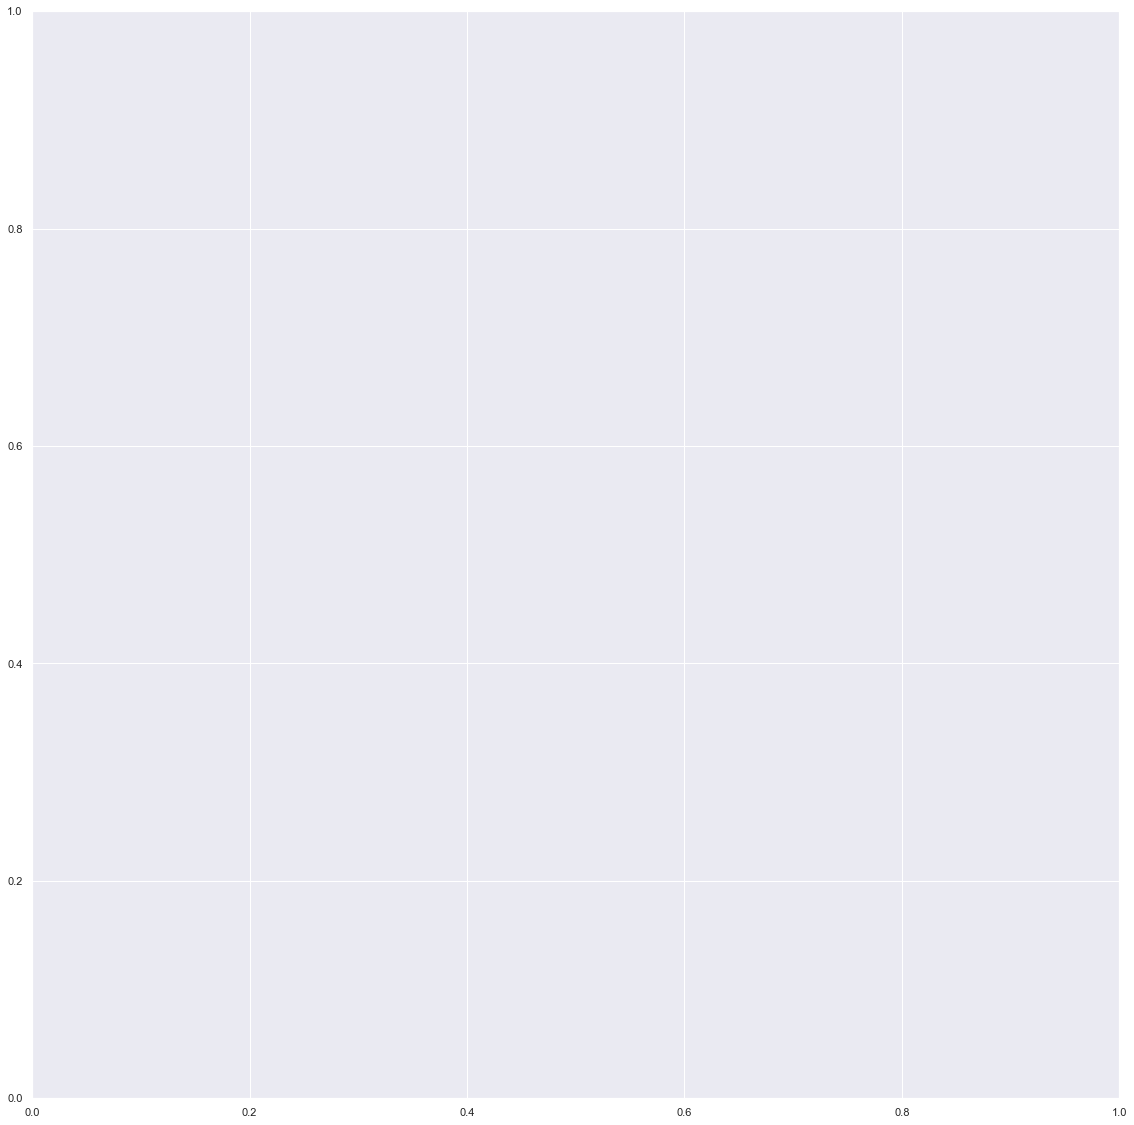

In [318]:
import mapclassify.classifiers as classifiers
merge.plot(column='count', scheme="naturalbreaks", k = 7,
           figsize=(25, 20),
           legend=True,cmap='Oranges',
          missing_kwds={
          "color": "lightgrey",
          "edgecolor": "white",
          "hatch": "///",
          "label": "Missing values"})
plt.title('Tweets Frequency in June 11th to 14th, 2021',fontsize=30, y = 1.05)
#plt.legend(fontsize=50)
# add countries names and numbers 
for i in range(len(merge.index)):
    if merge['count'][i] > 103:
        plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}".format(merge.country[i]),size=13, color = "k")
plt.show()